# Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов

## Введение / постановка задачи
Задача посвящена анализу производительности алгоритма решения задачи достижимости между всеми парами вершин и с заданным множеством стартовых вершин с регулярными ограничениями.

Исследуются три задачи достижимости, решаемые в предыдущих работах.
* Достижимость между всеми парами вершин.
* Достижимость для всего множества заданных вершин.
* Достижимость для каждой из заданного множества стартовых вершин.

Вопросы, на которые необходимо ответить в ходе исследования.
* Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
* Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
* На сколько решение третьей задачи медленнее решения второй при одинаковых начальных условиях?

## Описание исследуемых решений
* *Достижимость между всеми парами вершин* реализована с помощью тензорного произведения.
* *Достижимость для всего множества заданных вершин* реализована с помощью итеративного произведения графа на фронт (breadth-first search) для всех стартовых вершин.
* *Достижимость для каждой вершины из заданного множества* стартовых вершин реализована с помощью итеративного произведения графа на фронт (breadth-first search), где у каждой стартовой вершины фронт свой.

## Зависимости

In [ ]:
!git clone https://github.com/lastdesire/formal-lang-course.git
%cd formal-lang-course
!git checkout Task_5
!git pull
!pip install -r requirements.txt
!pip install matplotlib

## Импорты

In [18]:
import sys
sys.path.insert(0, "/content/formal-lang-course")

import cfpq_data as cd
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyformlang.regular_expression as re
import pyformlang.finite_automaton as fa
from scipy import stats
from scipy.sparse import csc_matrix, csr_matrix, dok_matrix, lil_matrix
import textwrap
import time

from functools import reduce
from typing import List
from typing import Tuple
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

from project.automaton_utils import *
from project.graph_utils import *
from project.sparse_matrix_utils import *

import logging

In [19]:
logging.disable(logging.INFO)

## Описание набора данных для экспериментов

### Графы

Для проведения эксперимента были выбраны графы из [датасета Python пакета CFPQ_Data](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html).

Сам датасет, естественно, содержит в себе графы, обладающие куда бОльшим количеством вершин и ребер (информацию о выбранных графах смотрите ниже), однако протестировать эти графы на нашем оборудовании является достаточно затруднительной задачей, поскольку выполнение алгоритмов на нем занимает чрезвычайно много времени.

In [20]:
GRAPHS = ["wc", "generations", "travel", "univ", "atom", "biomedical", "bzip",
            "foaf", "people", "pr", "funding", "ls", "wine", "pizza", "gzip", "core"]

def graphs_info() -> pd.DataFrame:
    stats = []
    for graph in GRAPHS:
        info = get_graph_info(graph)
        stats.append([
            graph,
            info.number_of_nodes,
            info.number_of_edges,
            info.sorted_labels_list,
        ])

    return pd.DataFrame(
        sorted(stats, key=lambda st: st[2]),
        columns=["Graph", "Nodes", "Edges", "Labels [from the most common to less]"],
    )


pd.set_option("display.max_colwidth", None)
graphs_info()

Graph  Nodes  Edges  \
0            wc    332    269   
1   generations    129    273   
2        travel    131    277   
3          univ    179    293   
4          atom    291    425   
5    biomedical    341    459   
6          bzip    632    556   
7          foaf    256    631   
8        people    337    640   
9            pr    815    692   
10      funding    778   1086   
11           ls   1687   1453   
12         wine    733   1839   
13        pizza    671   1980   
14         gzip   2687   2293   
15         core   1323   2752   

                                                                                                                                                                                                                                                                                                                                                                                     Labels [from the most common to less]  
0                                                                                                                                                                                                                                                                                                                                                                                                                   [d, a]  
1                                                                                                                                                                                                                                        [type, first, rest, onProperty, intersectionOf, equivalentClass, someValuesFrom, hasValue, hasSex, hasChild, hasParent, inverseOf, sameAs, hasSibling, oneOf, range, versionInfo]  
2                                                                                                                                                             [type, subClassOf, first, rest, disjointWith, onProperty, domain, range, someValuesFrom, comment, equivalentClass, intersectionOf, differentFrom, hasValue, hasPart, inverseOf, minCardinality, oneOf, complementOf, hasAccommodation, unionOf, versionInfo]  
3                                                                                                                                                                                                                                                                        [type, label, subClassOf, domain, range, first, rest, onProperty, someValuesFrom, intersectionOf, subPropertyOf, inverseOf, comment, versionInfo]  
4                                                                                                                                                                                                                                                          [type, label, subClassOf, comment, domain, range, subPropertyOf, creator, date, description, format, imports, language, publisher, seeAlso, title, versionInfo]  
5                                                                                                                                                                                                                                                                                                                        [type, label, subClassOf, comment, creator, description, language, publisher, title, versionInfo]  
6                                                                                                                                                                                                                                                                                                                                                                                                                   [d, a]  
7                                                                                                                                               

### Запросы

Запросы ко всем графам следуют некоторому общему шаблону. Также в запросах нами использовались все общепринятые конструкции регулярных выражений (замыкание, конкатенация, альтернатива). 
* $(l_1 \ | \ l_2)$.
* $(l_1 \ | \ l_2)^* \ l_3$.
* $(l_3 \ | \ l_4)^+ \ l_1^*$.
* $l_1 \ l_2 \ l_3 \ (l_4 \ | \ l_1)^*$.

Здесь $l_1, l_2, l_3, l_4$ --- это наиболее встречающиеся метки в конкретном графе.

Стоит отметить, что если обе метки встречаются одинаковое количество раз, и они обе являются кандидатами, например, на $l_4$, то приоритет будет отдан метке в соответствии с алфавитным порядком.

Помимо этого, если граф содержит менее четырех меток, то далее мы берем их повторно в аналогичном порядке (например, если граф содержит метки ${'}a{'}$ и ${'}b{'}$ [где первая встречается чаще], то $l_1 = l_3 = {'}a{'}, \ l_2 = l_4 = {'}b{'}$).

Ниже приведен код, позволяющий генерировать регулярные выражения в соответствии с наиболее встречающимися метками в графе.

In [21]:
def r1(l1: str, l2: str, _: str, __: str) -> re.Regex:
    return Regex(l1).union(Regex(l2))


def r2(l1: str, l2: str, l3: str, _: str) -> re.Regex:
    return Regex(l1).union(Regex(l2)).kleene_star().concatenate(Regex(l3))


def r3(l1: str, _: str, l3: str, l4: str) -> re.Regex:
    return Regex(l3).union(Regex(l4)).concatenate(Regex(l3).union(Regex(l4)).kleene_star()).concatenate(Regex(l1).kleene_star())


def r4(l1: str, l2: str, l3: str, l4: str) -> re.Regex:
    return Regex(l1).concatenate(Regex(l2)).concatenate(Regex(l3)).concatenate(Regex(l4).union(Regex(l1)).kleene_star())


REGEXES = {
    "(l1 | l2)": r1,
    "(l1 | l2)* l3": r2,
    "(l3 | l4)+ l1*": r3,
    "l1 l2 l3 (l4 | l1)*": r4
}

REGEXES_LIST = ["(l1 | l2)", "(l1 | l2)* l3", "(l3 | l4)+ l1*", "l1 l2 l3 (l4 | l1)*"]

def take_graph_regexes(graph: nx.Graph) -> List[re.Regex]:
    labels = get_graph_info(graph).sorted_labels_list
    while len(labels) < 4:
        labels += labels
    return [r(*(labels[:4])) for r in REGEXES.values()]

Взглянем далее на число состояний и переходов регулярных выражений выше, представленных в виде конечных автоматов (ведь любое РВ эквивалентно некоторому КА).

In [22]:
def regexes_info() -> pd.DataFrame:
    stats = []

    for s, r in [(s, r("_", "__", "___", "____")) for s, r in REGEXES.items()]:
        min_dfa = regex_to_min_dfa(r)
        stats.append([
            s,
            len(min_dfa.symbols),
            len(min_dfa.states),
            min_dfa.get_number_transitions(),
        ])

    return pd.DataFrame(stats, columns=["Regex", "Symbols", "States", "Transitions"])


regexes_info()

Regex  Symbols  States  Transitions
0            (l1 | l2)        2       2            2
1        (l1 | l2)* l3        3       2            3
2       (l3 | l4)+ l1*        3       3            6
3  l1 l2 l3 (l4 | l1)*        4       4            5

### Типы матриц
Будем сравнивать следующие представления разреженных матриц.
* [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html).
* [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html).
* [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html).
* [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).

## Описание эксперимента

### Оборудование

In [32]:
!echo "#################### HARDWARE ####################"
!echo "Hardware:\n\nHardware Overview:\n\nModel Name: MacBook Air\nModel Identifier: MacBookAir10,1\nChip: Apple M1\nTotal Number of Cores: 8 (4 performance and 4 efficiency)\nMemory: 16 GB"
!echo "\n Use command 'system_profiler SPSoftwareDataType SPHardwareDataType' for getting your hardware overview (MacOS)."

#################### HARDWARE ####################
Hardware:

Hardware Overview:

Model Name: MacBook Air
Model Identifier: MacBookAir10,1
Chip: Apple M1
Total Number of Cores: 8 (4 performance and 4 efficiency)
Memory: 16 GB

 Use command 'system_profiler SPSoftwareDataType SPHardwareDataType' for getting your hardware overview (MacOS).


### Замеры
Замеры времени проводились с помощью Python библиотеки [time](https://docs.python.org/3/library/time.html). Время работы каждого алгоритма на каждом из входных данных замерялось нами десять раз, далее получалось среднее арифметическое и стандартное отклонение.

## Наборы данных: стартовые и финальные вершины


Множество стартовых вершин генерировалось нами при помощи функции [generate_multiple_source_percent (CFPQ_data)](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source_percent) с определенным значением параметра *seed*, что обеспечивает воспроизводимость эксперимента. Поскольку требуется изучить влияние размера стартового множества на время работы, то будем проводить измерения с различным значением параметра *percent*.

In [24]:
SEED = 17
PERCENT = 10.0
RUN_NUMBER = 10
MATRIX_TYPES = [csc_matrix, csr_matrix, dok_matrix, lil_matrix]

Cтоит отметить, что множество финальных вершин влияет на каждый из алгоритмов аналогичным образом, поэтому мы принимаем все вершины графа за финальные.

## Код

In [25]:
def draw_diagram(graph_name, percent, matrix_time, matrix_digression, matrices_type):
    index = np.arange(0, 4, 1)
    bw = 0.19
    plt.title(graph_name + " (PERCENT:" + str(percent) + "%)")
    colors = ["g", "b", "m", "gold"]
    for count, matrix_name in enumerate(matrices_type):
        plt.bar(index + (count + 1) * bw, matrix_time[matrix_name.__name__], bw,
                yerr=matrix_digression[matrix_name.__name__],
                error_kw={'ecolor': '0.1', 'capsize': 6}, alpha=0.7, color=colors[count], label=matrix_name.__name__)

    plt.xticks(index + bw, REGEXES_LIST)
    plt.legend(loc=1)
    plt.show()


def _rpq(percent=PERCENT, type_matrices=MATRIX_TYPES, rpq_type=bfs_rpq, foreach_start_node=True):
    for graph_name in GRAPHS:
        graph = cd.graph_from_csv(cd.download(graph_name))
        start_v = cd.generate_multiple_source_percent(graph, percent, seed=SEED)
        regexes = take_graph_regexes(graph_name)
        matrix_time = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        matrix_digression = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        for regex in regexes:
            for matrix_type in type_matrices:
                times = []
                for i in range(RUN_NUMBER):
                    start_time = time.time()
                    rpq_type(
                        graph, 
                        regex, 
                        start_v, 
                        None,
                        True,
                        matrix_type
                    )
                    final_time = time.time()
                    times.append(final_time - start_time)
                mean_time = np.mean(times)
                digression = stats.tstd(times)
                matrix_time[matrix_type.__name__].append(mean_time)
                matrix_digression[matrix_type.__name__].append(digression)
        draw_diagram(graph_name, percent, matrix_time, matrix_digression, type_matrices)


## Диаграммы
Note: столбцы в диаграммах показывают время работы в секундах!

### Достижимость между всеми парами вершин: tensor multy

Starting 'Достижимость между всеми парами вершин: tensor multy'...


/Users/noname/Documents/GitHub/formal-lang-course/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/noname/Documents/GitHub/formal-lang-course/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


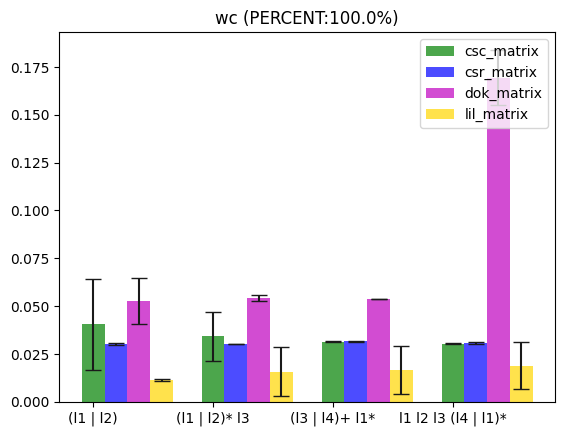

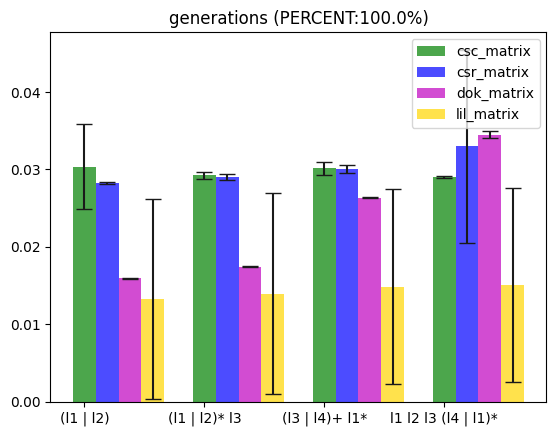

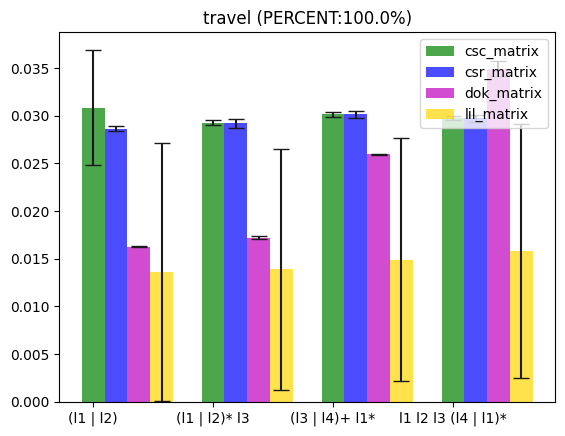

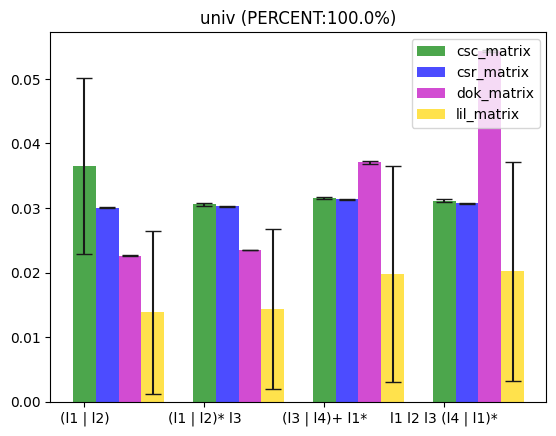

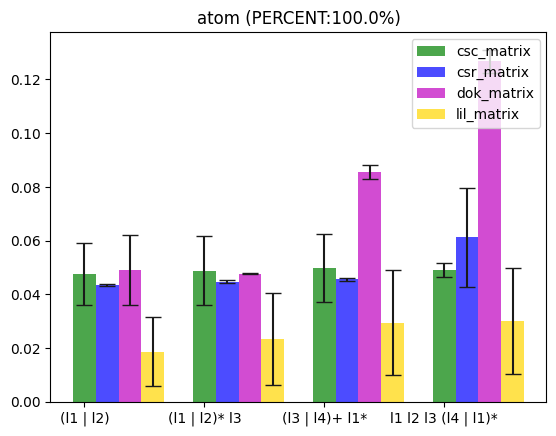

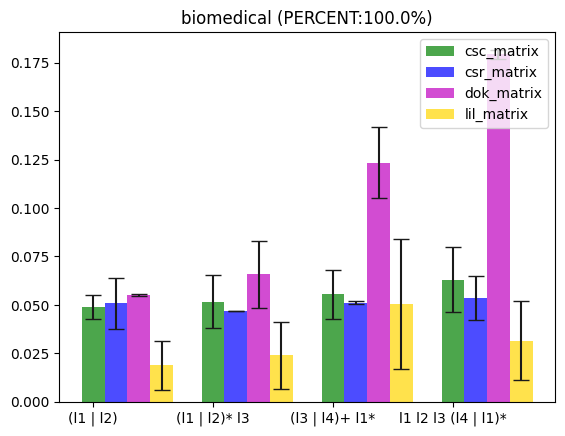

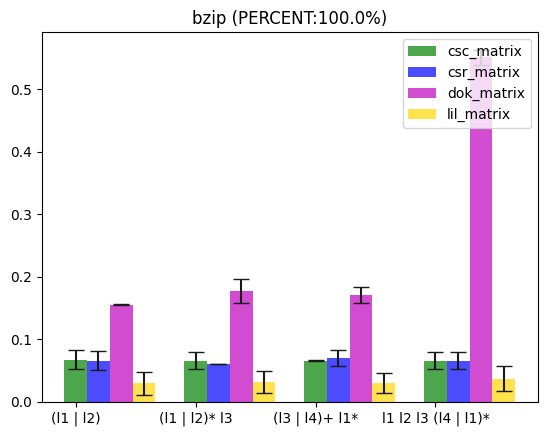

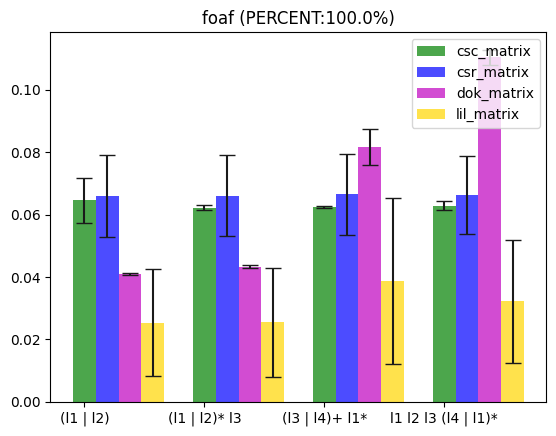

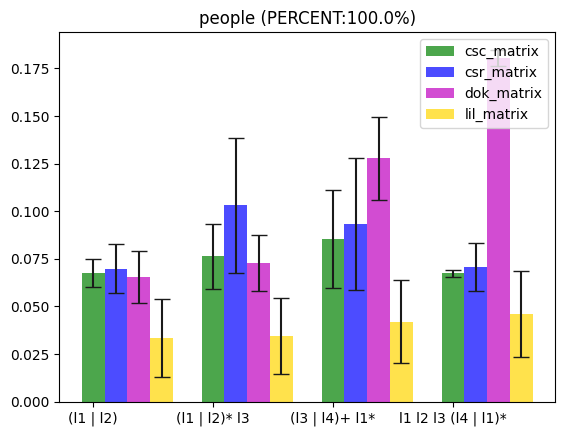

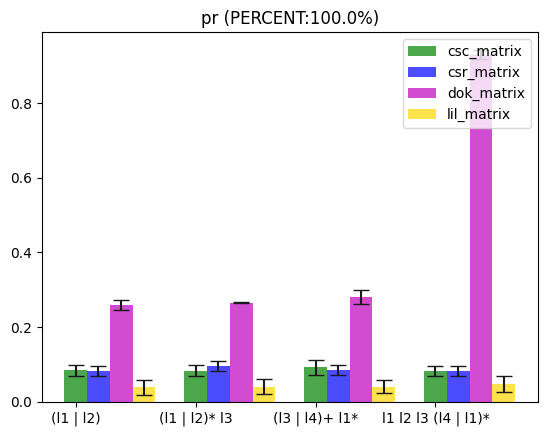

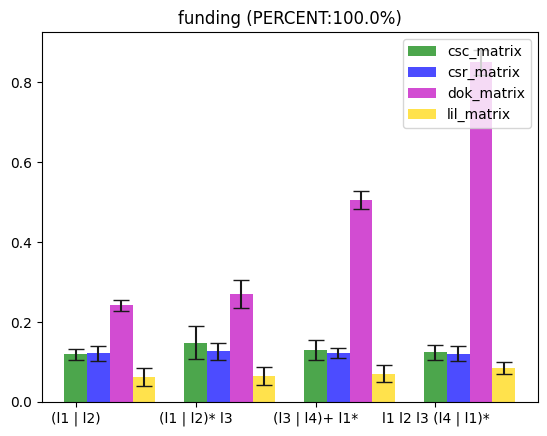

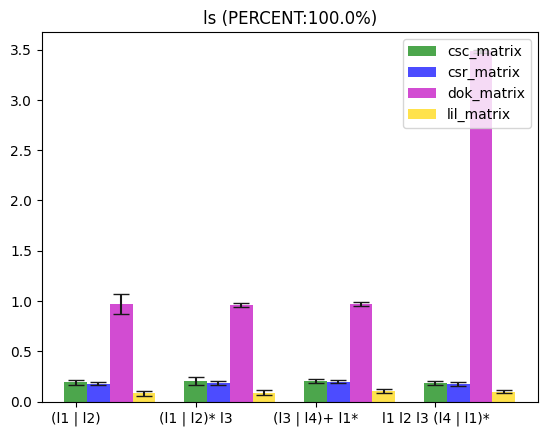

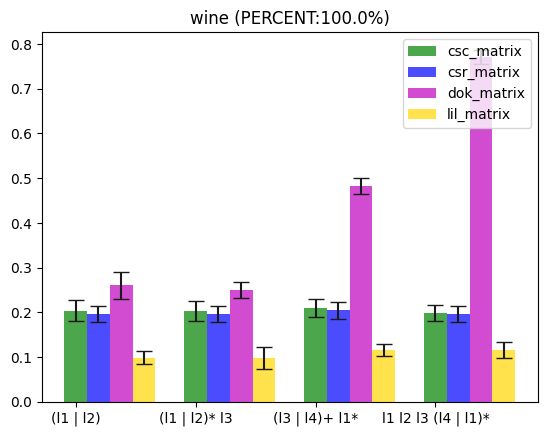

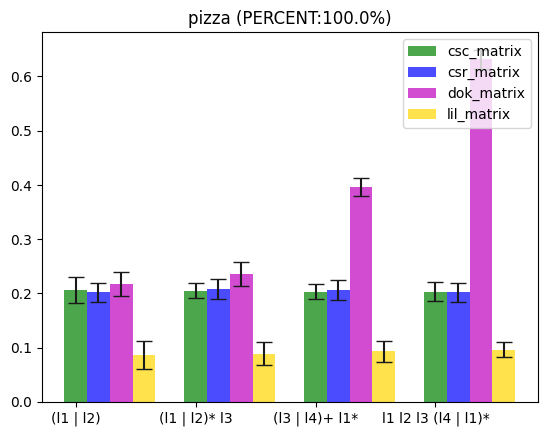

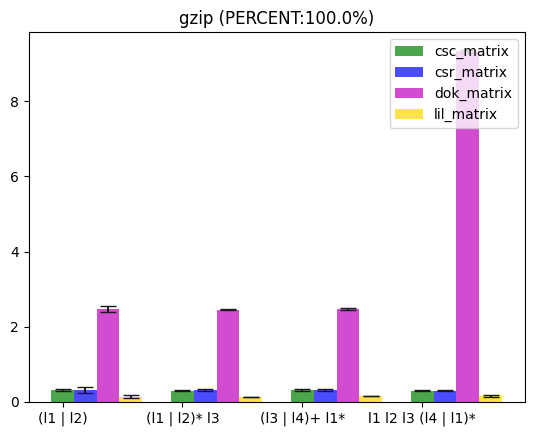

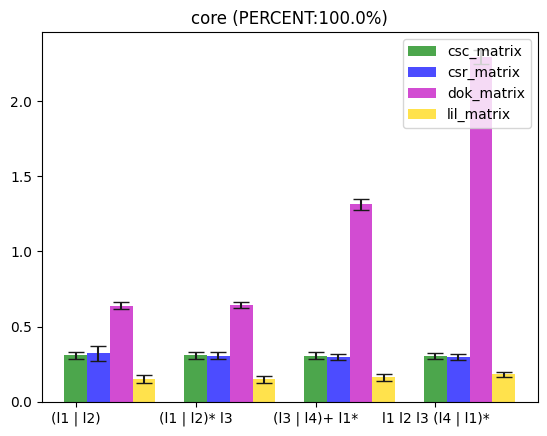

Done!


In [26]:
print("Starting 'Достижимость между всеми парами вершин: tensor multy'...")
_rpq(percent=100.0, rpq_type=rpq)
print("Done!")

### Достижимость между всеми парами вершин: bfs

Starting 'Достижимость между всеми парами вершин: bfs'...


/Users/noname/Documents/GitHub/formal-lang-course/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Users/noname/Documents/GitHub/formal-lang-course/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


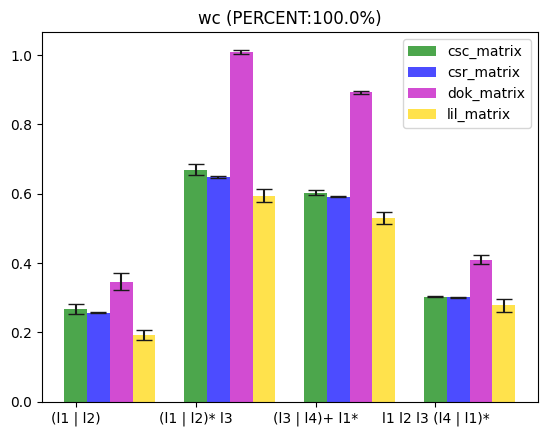

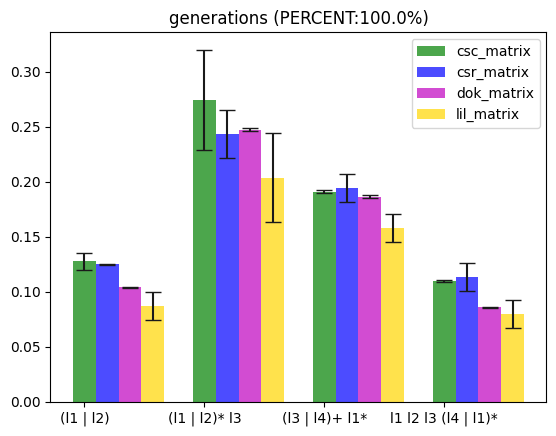

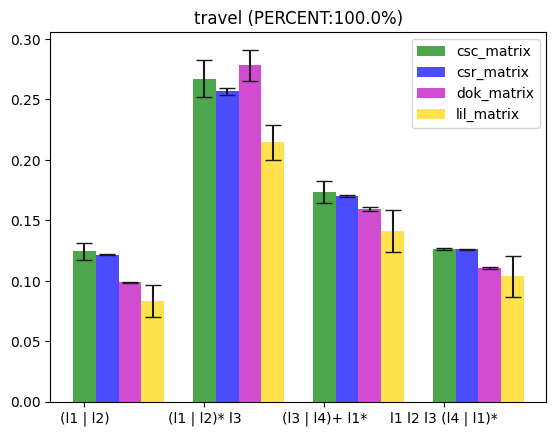

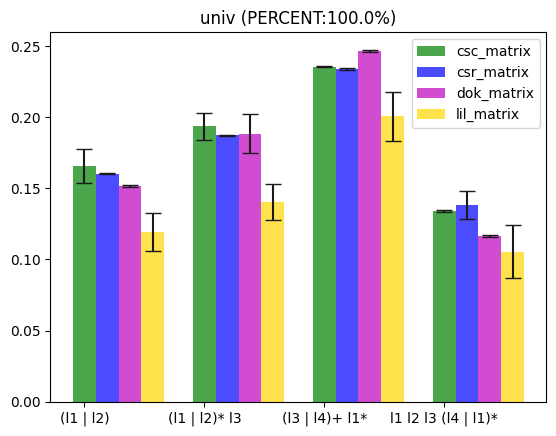

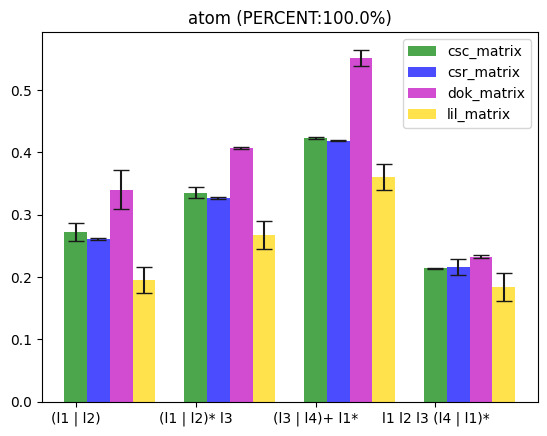

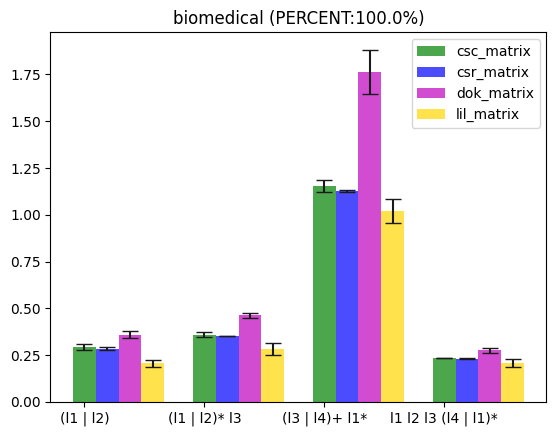

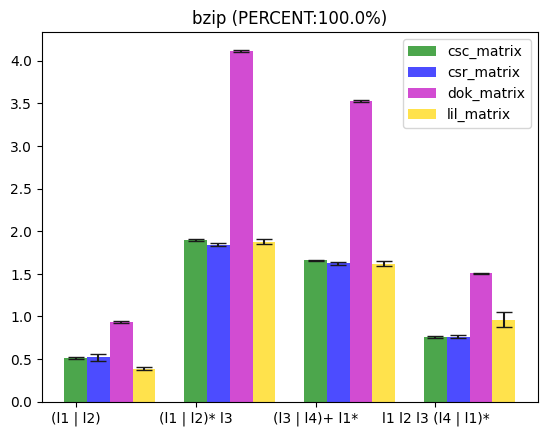

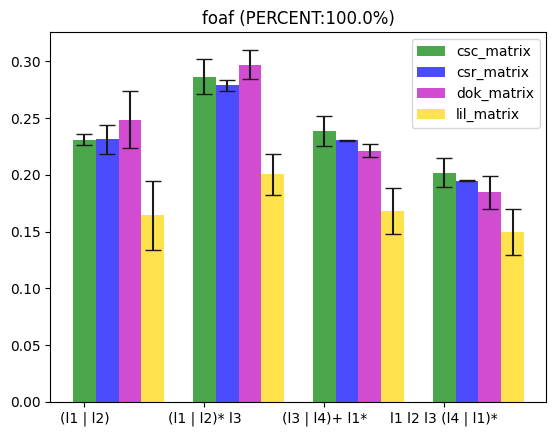

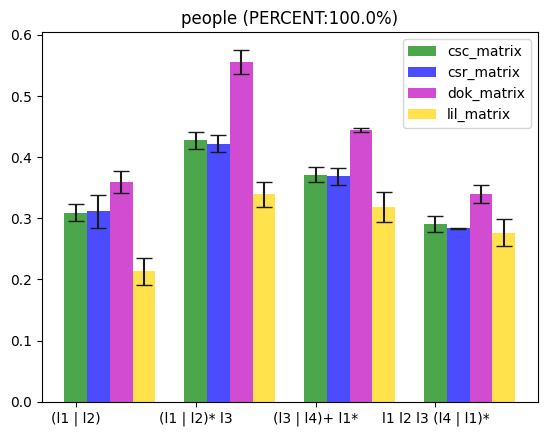

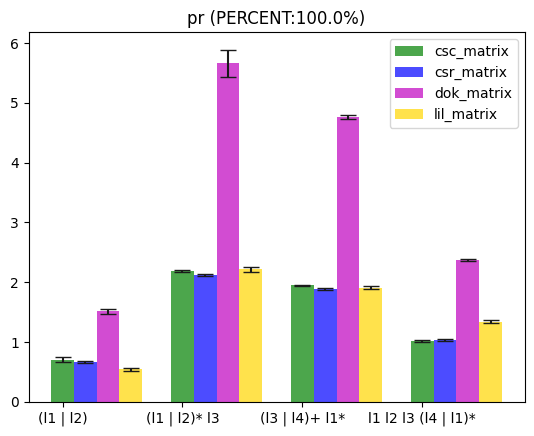

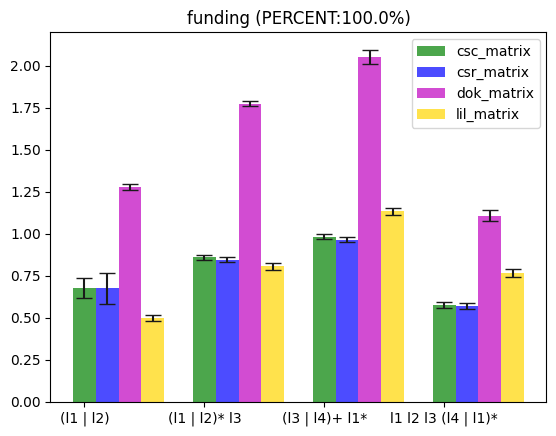

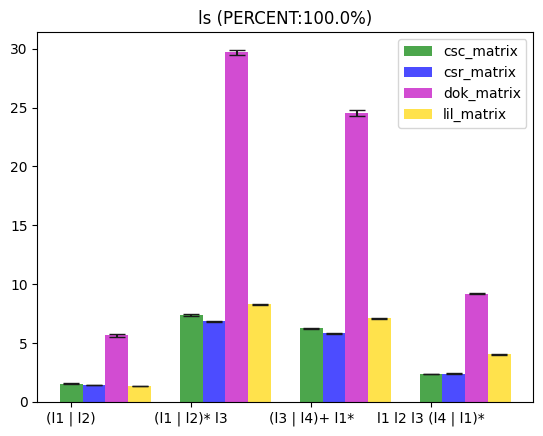

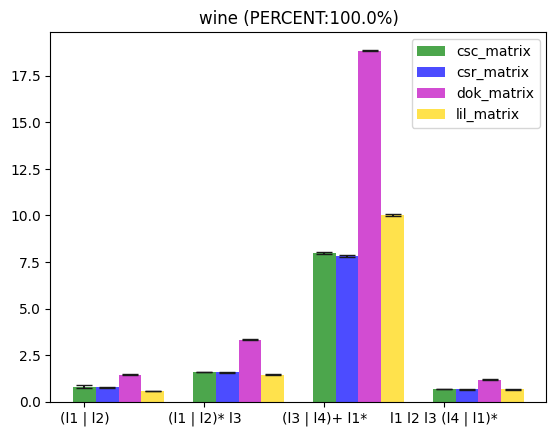

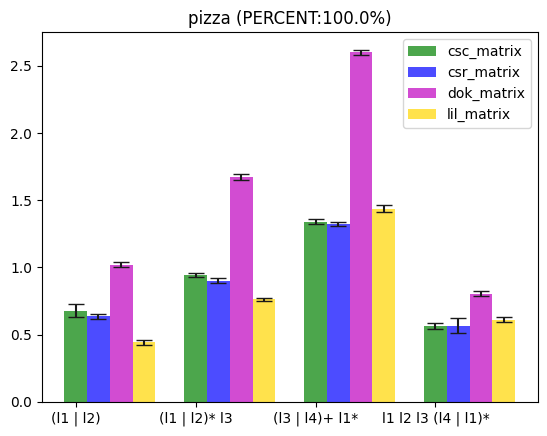

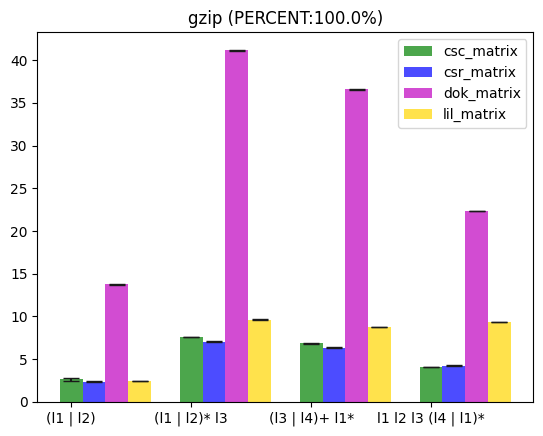

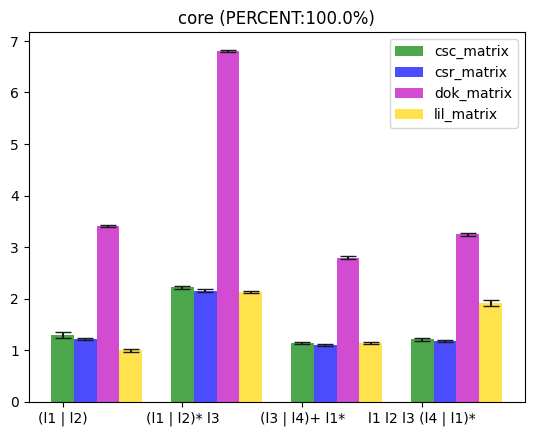

Done!


In [27]:
print("Starting 'Достижимость между всеми парами вершин: bfs'...")
_rpq(percent=100.0, rpq_type=bfs_rpq)
print("Done!")

### Достижимость для всего множества заданных вершин: tensor multy

Starting 'Достижимость для всего множества заданных вершин: tensor multy'...


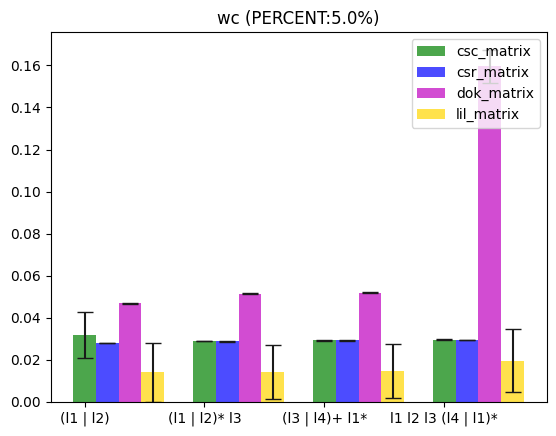

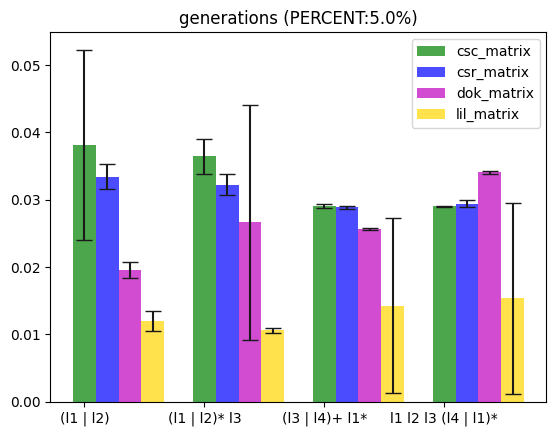

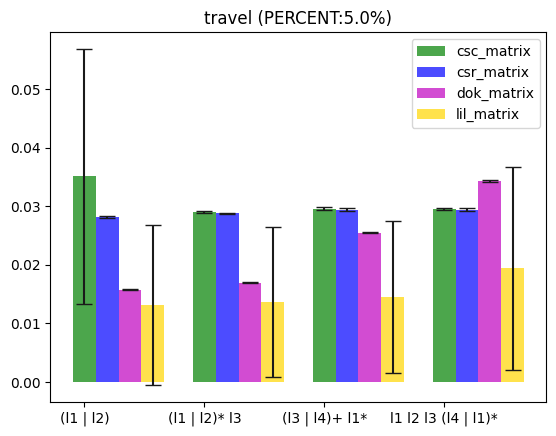

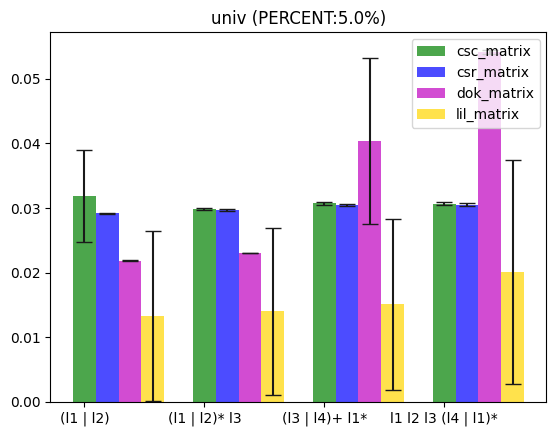

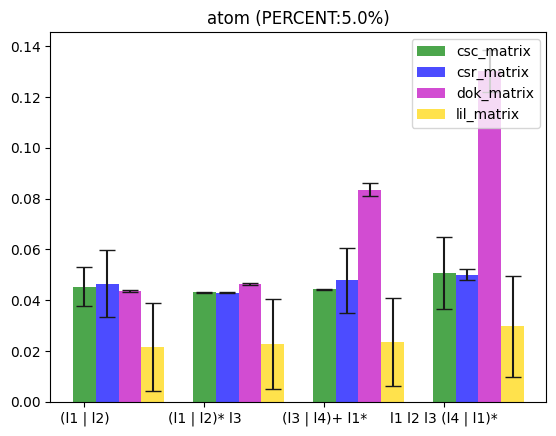

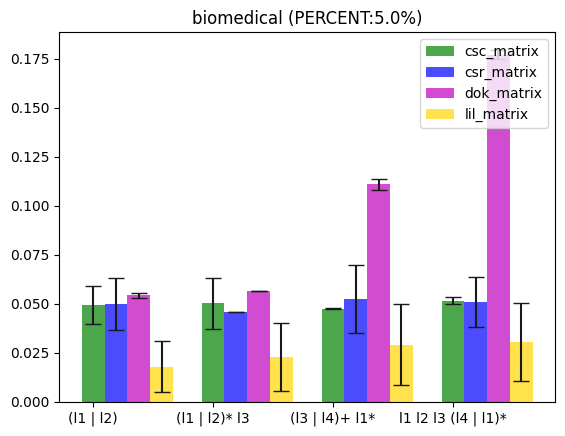

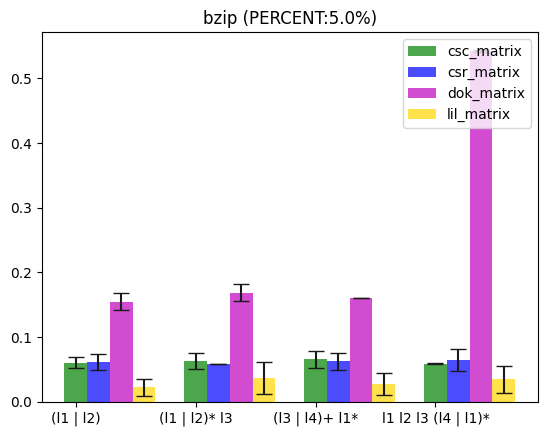

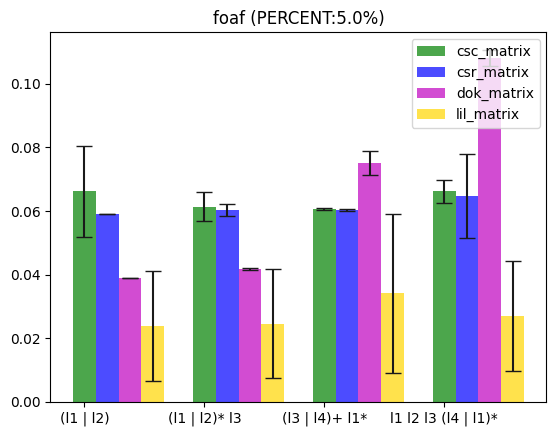

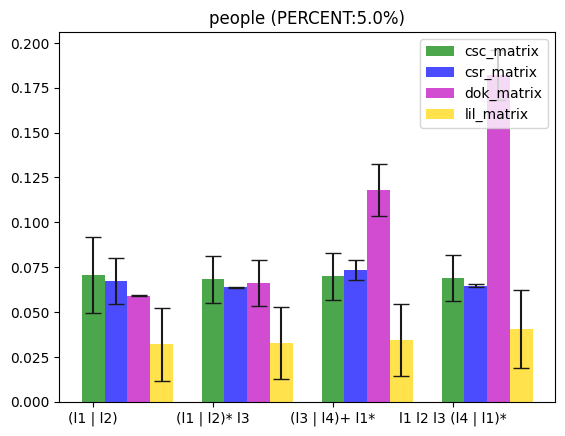

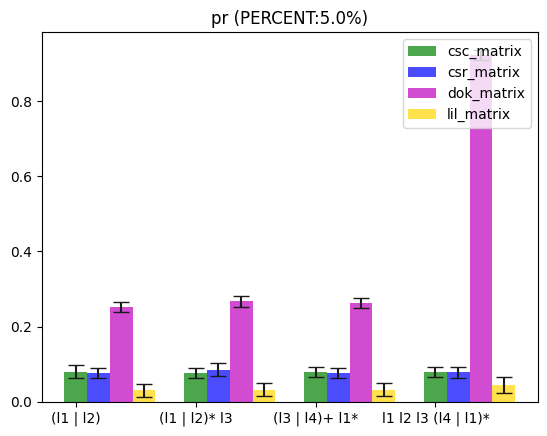

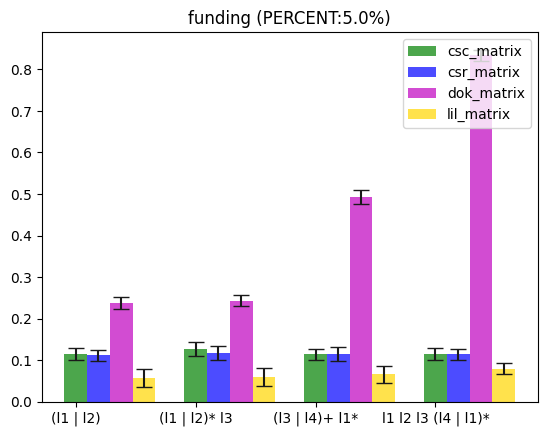

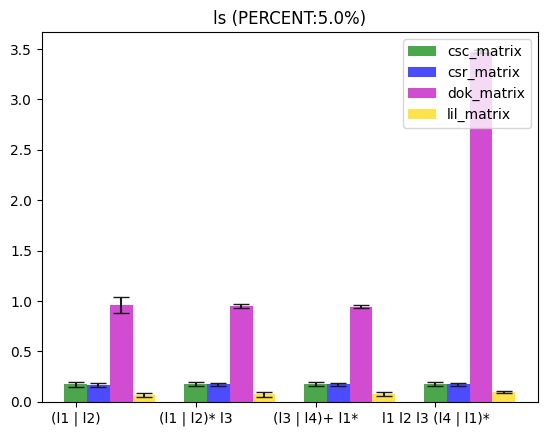

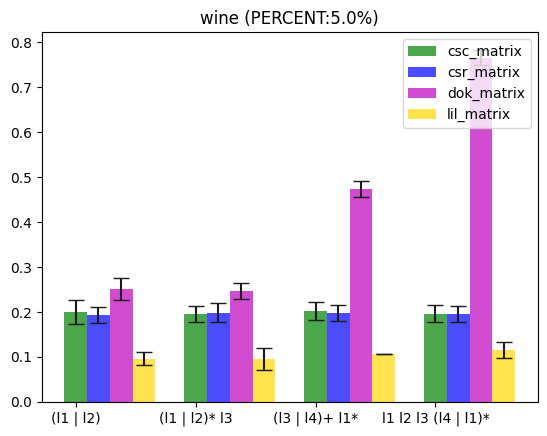

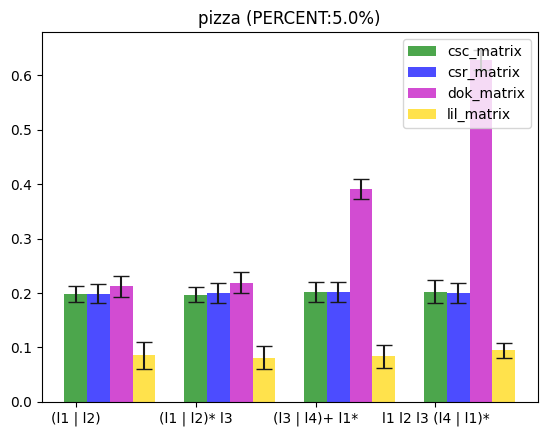

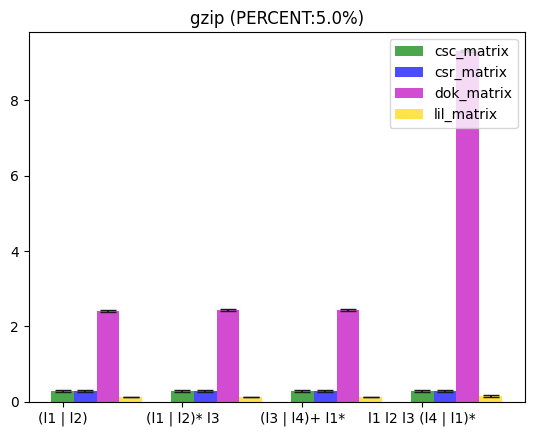

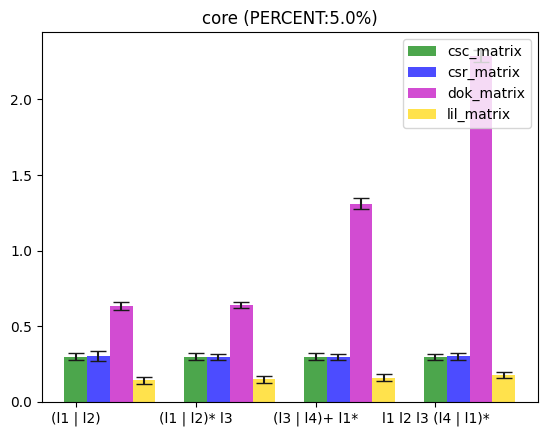

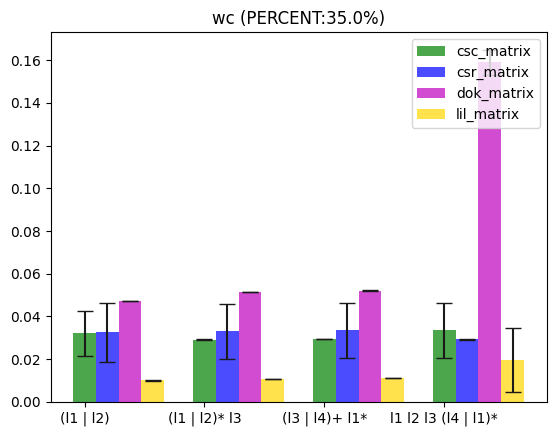

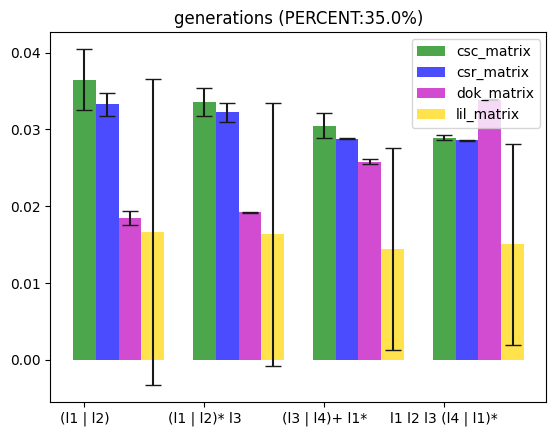

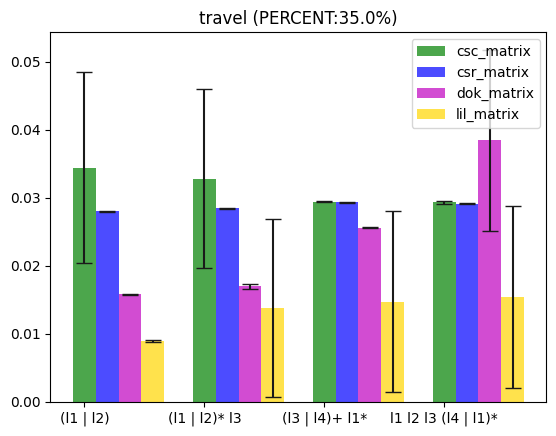

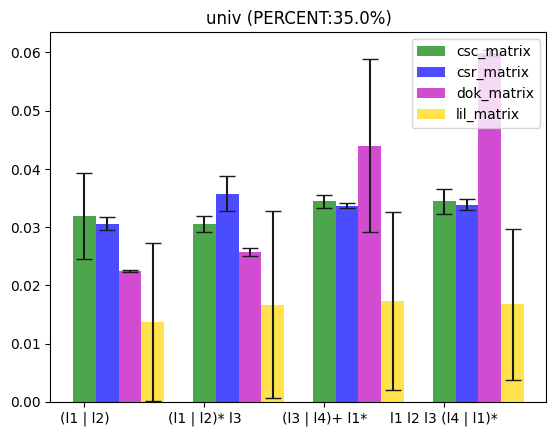

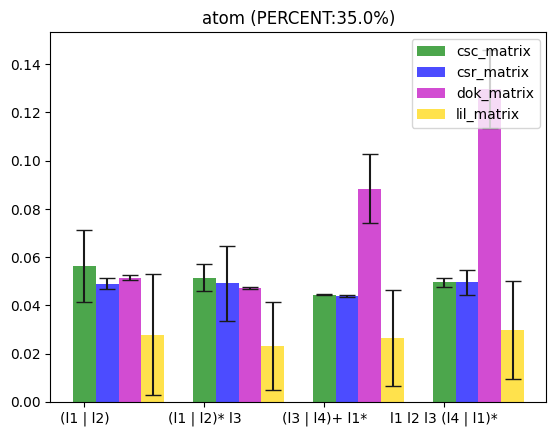

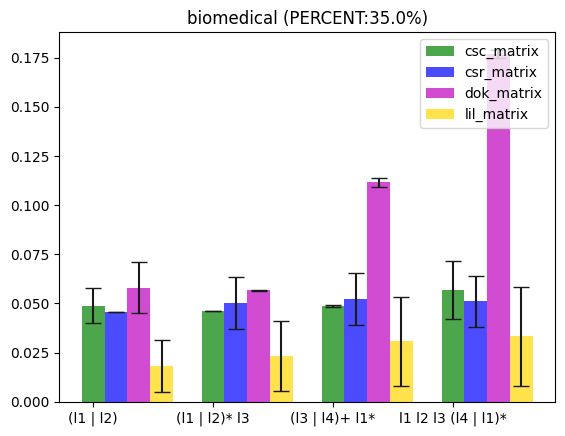

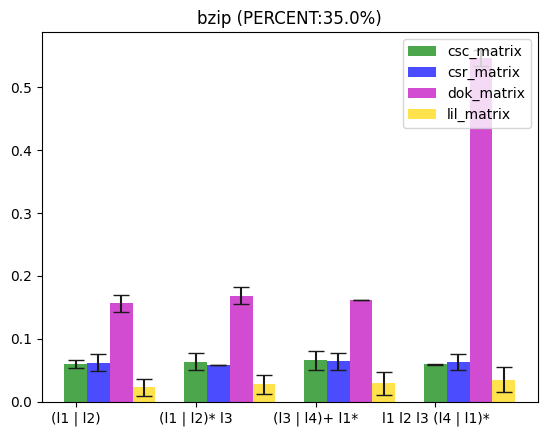

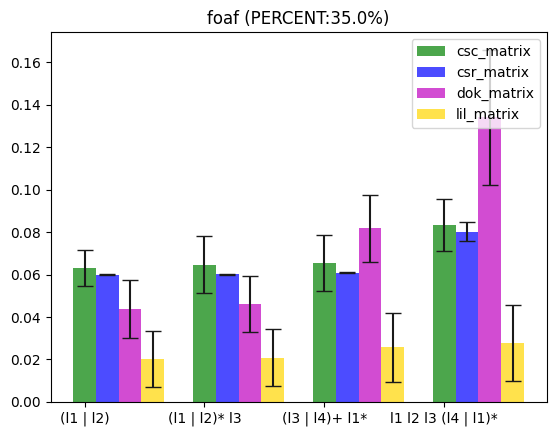

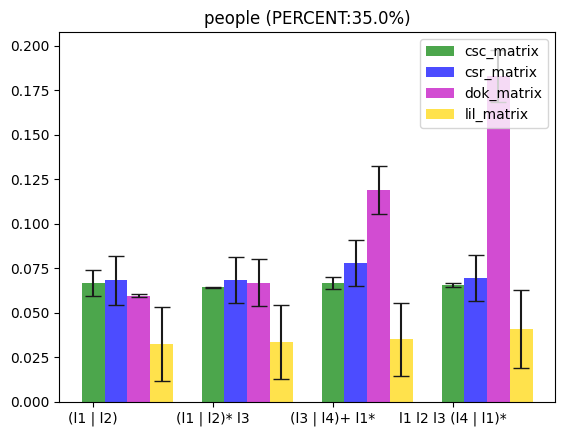

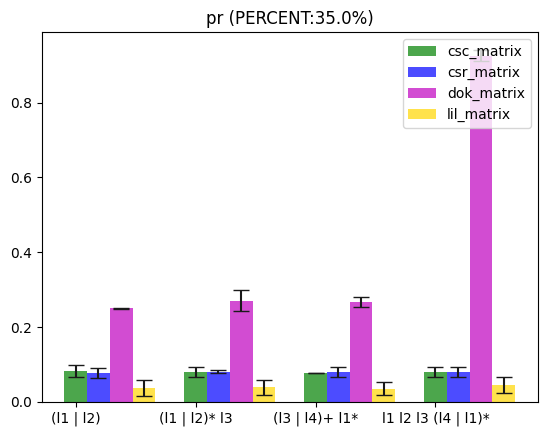

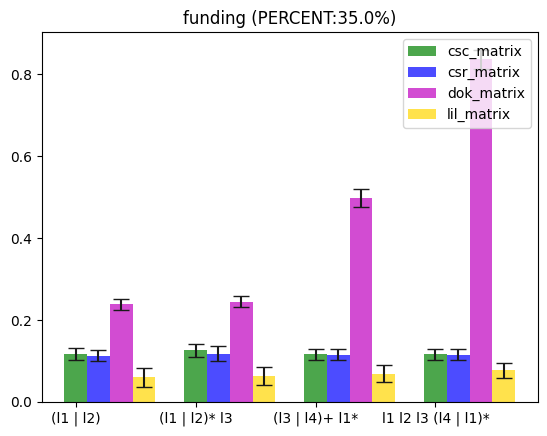

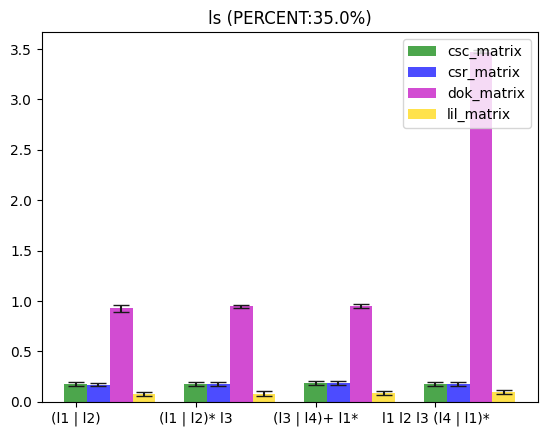

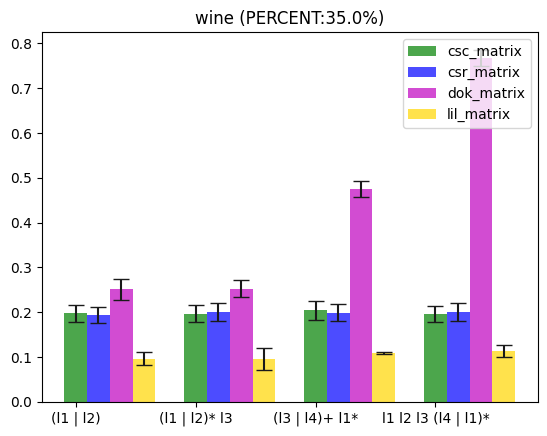

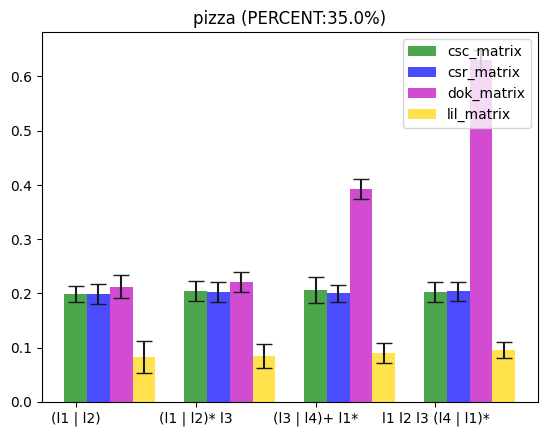

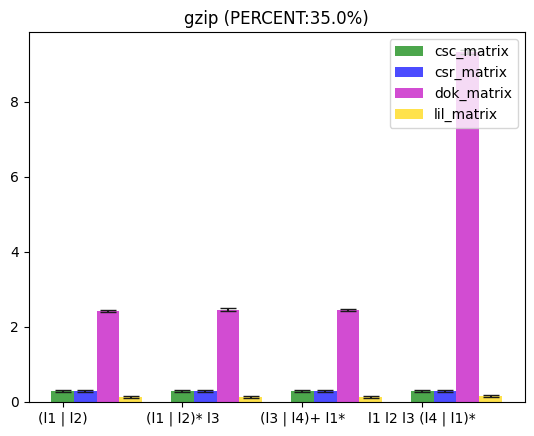

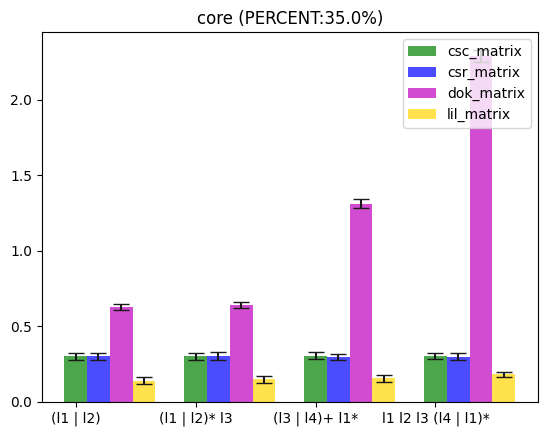

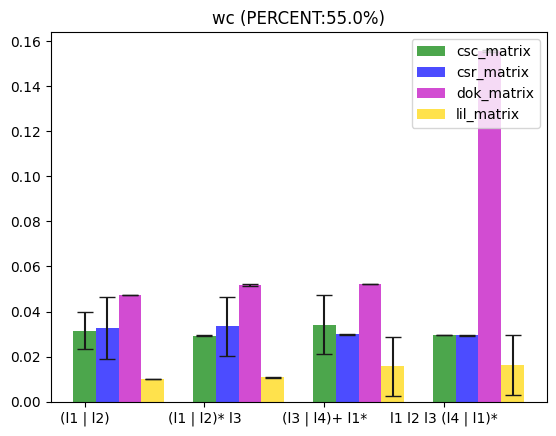

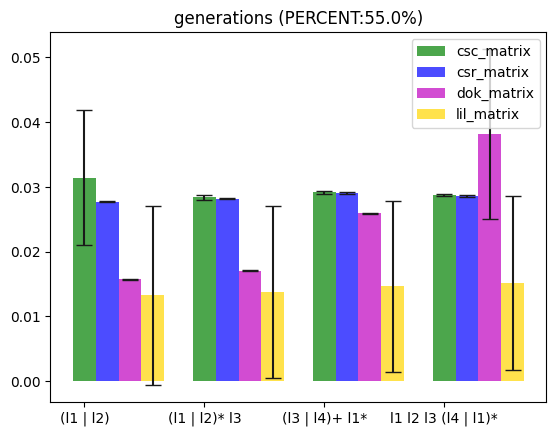

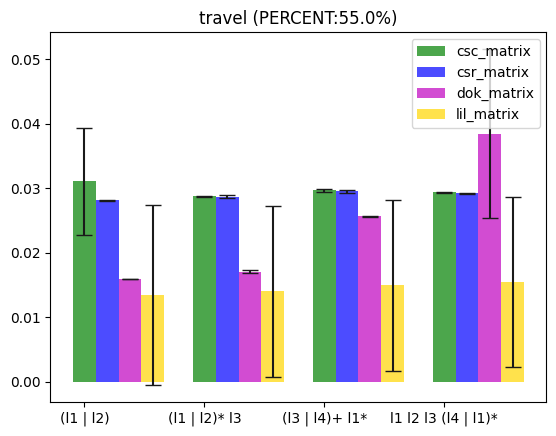

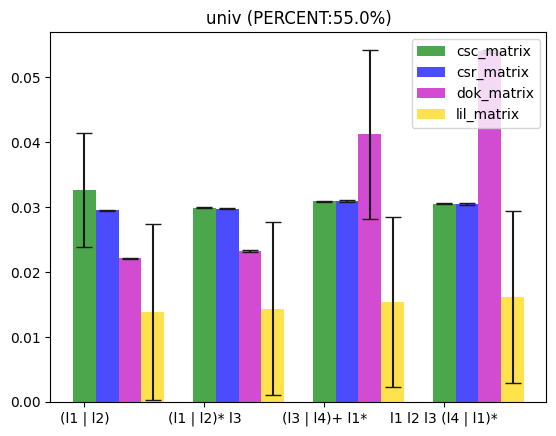

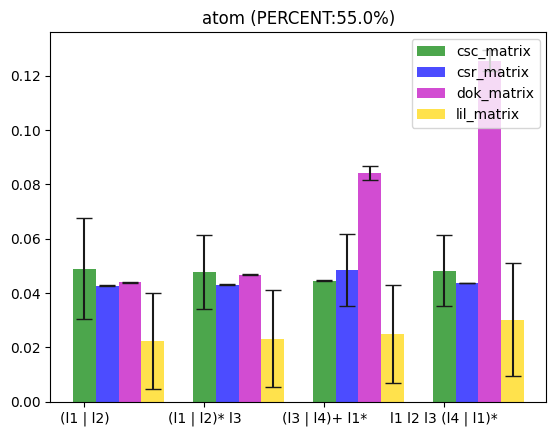

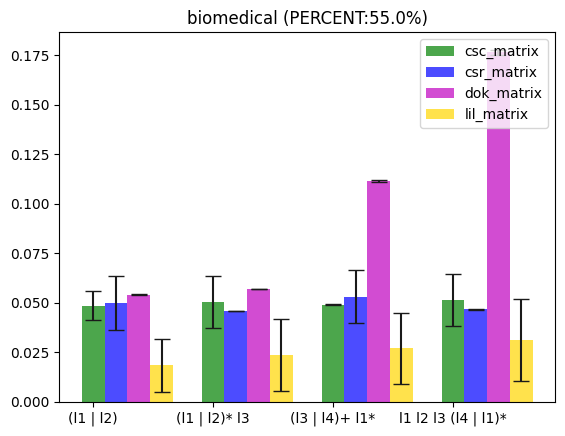

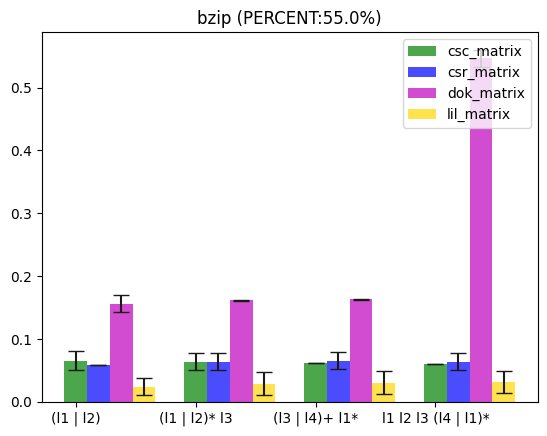

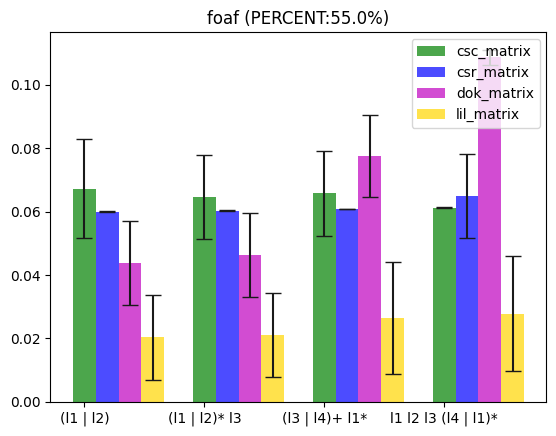

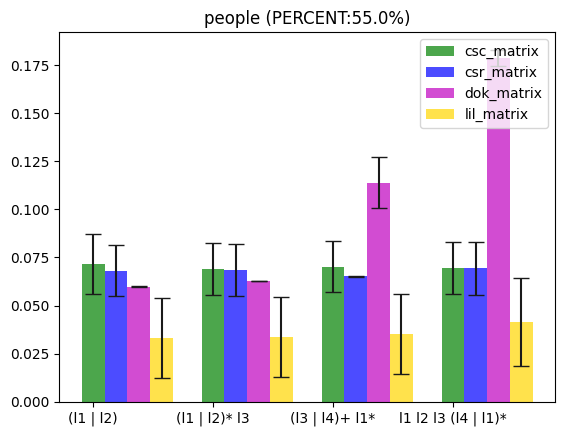

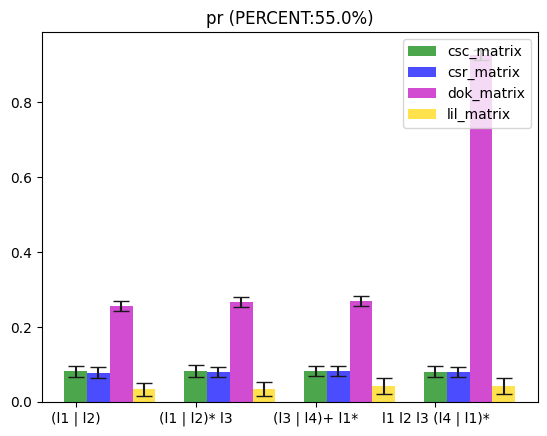

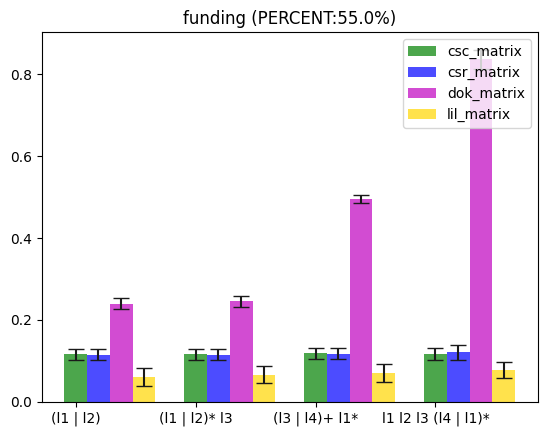

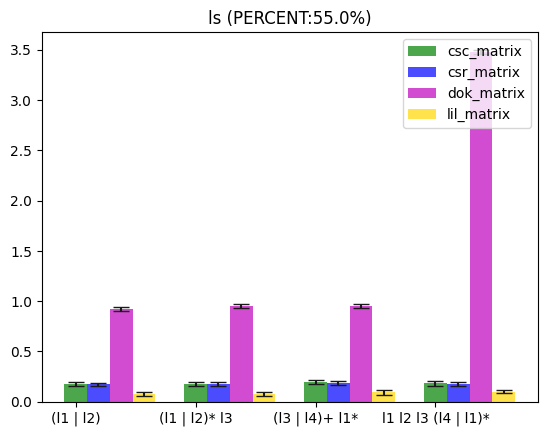

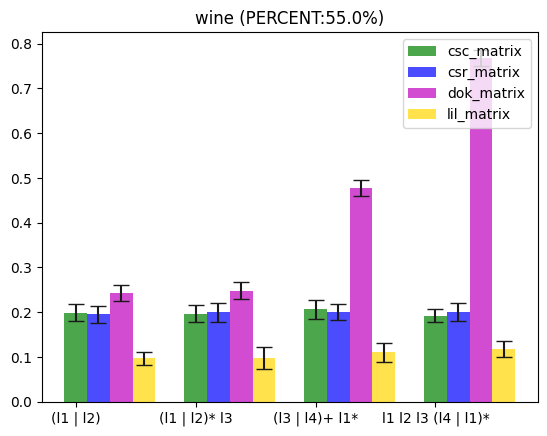

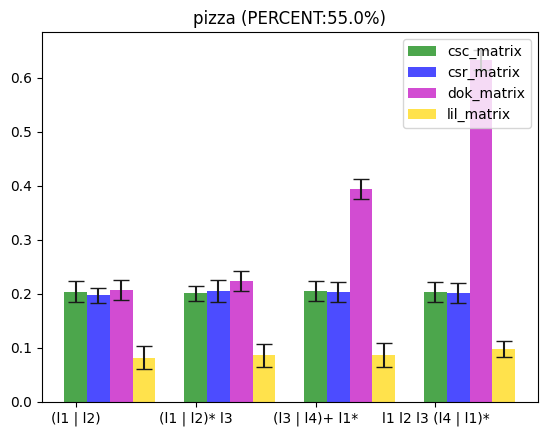

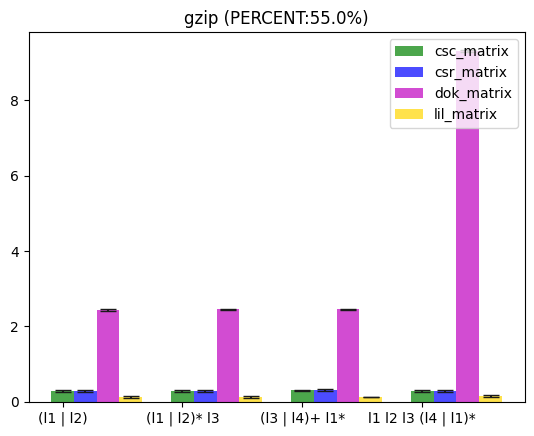

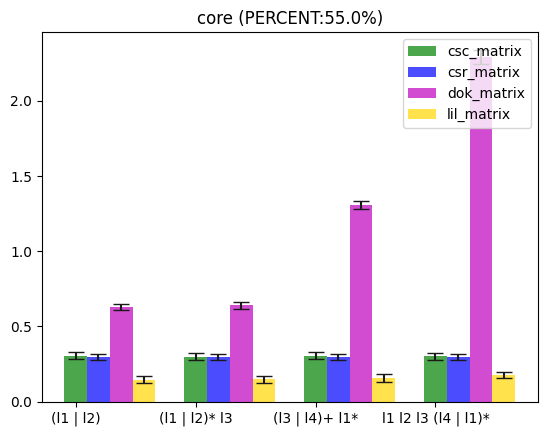

In [29]:
print("Starting 'Достижимость для всего множества заданных вершин: tensor multy'...")
percents = [5.0, 35.0, 55.0]
for percent in percents:
    _rpq(percent=percent, rpq_type=rpq, foreach_start_node=False)

### Достижимость для всего множества заданных вершин: bfs

Starting 'Достижимость для всего множества заданных вершин: bfs'...


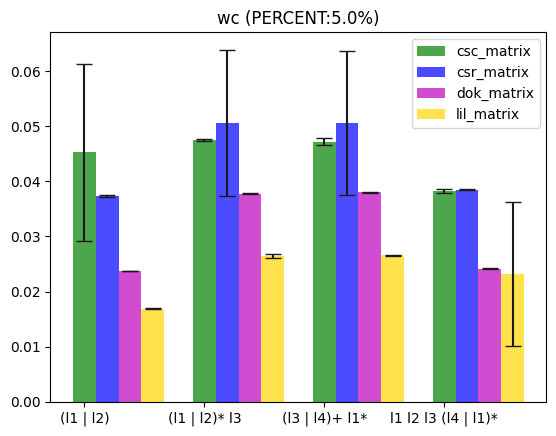

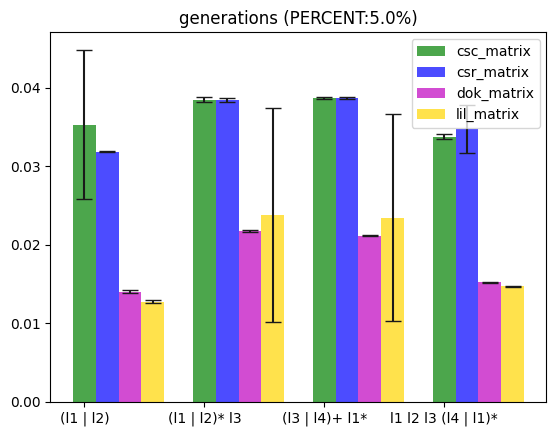

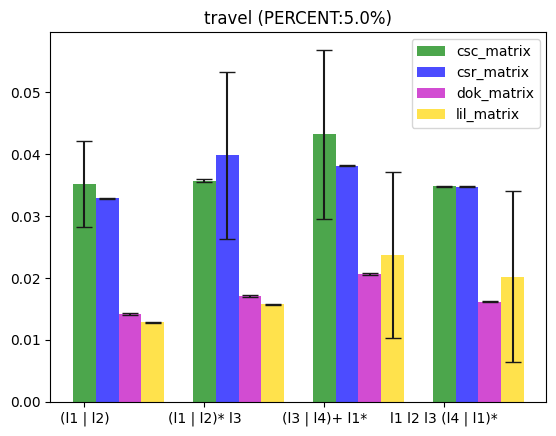

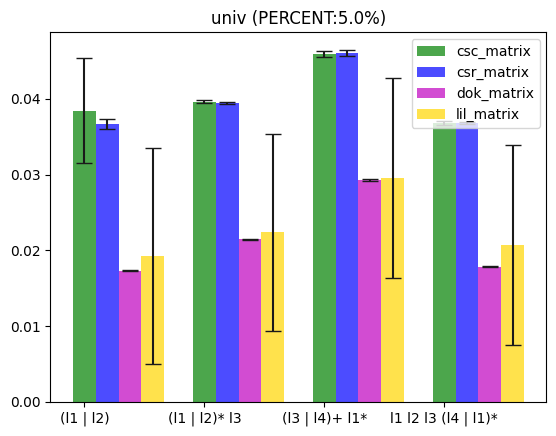

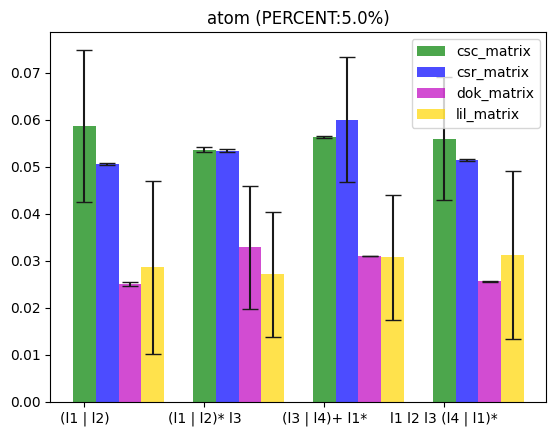

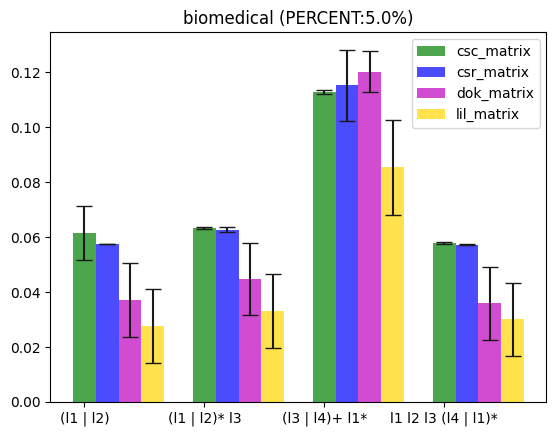

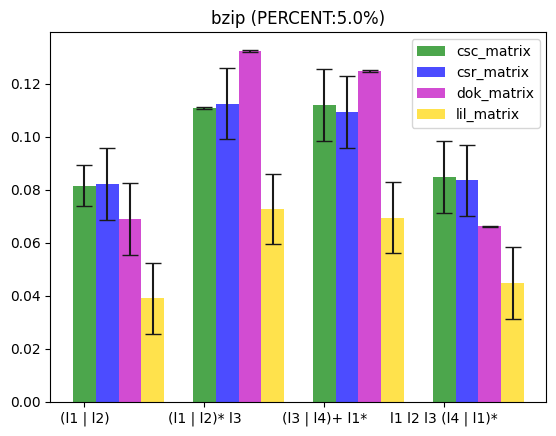

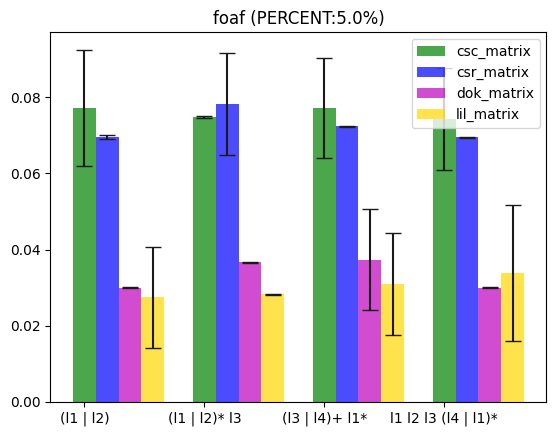

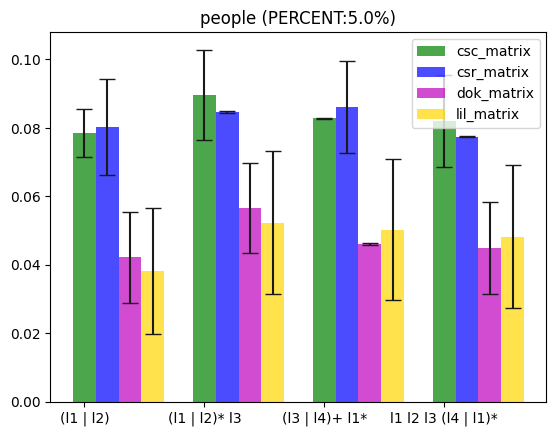

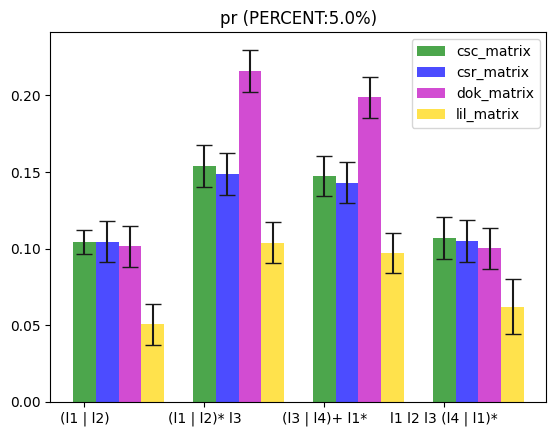

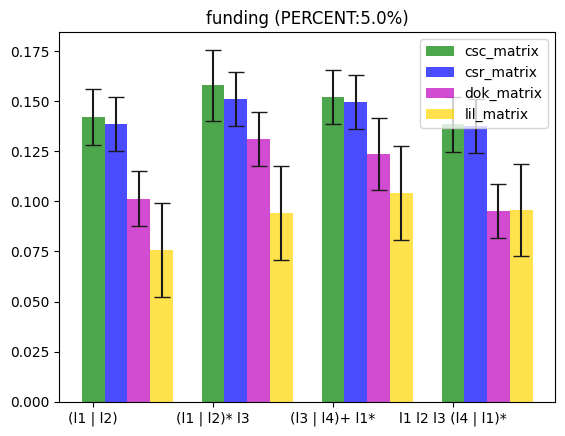

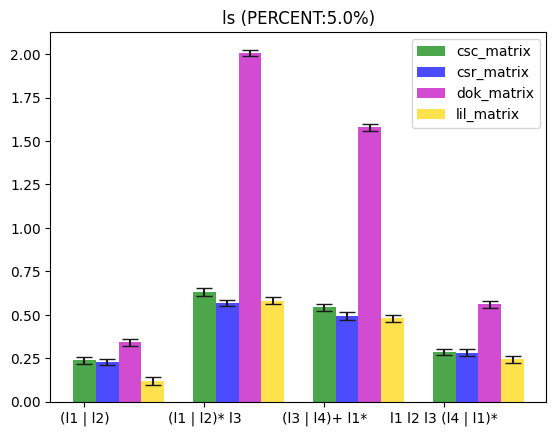

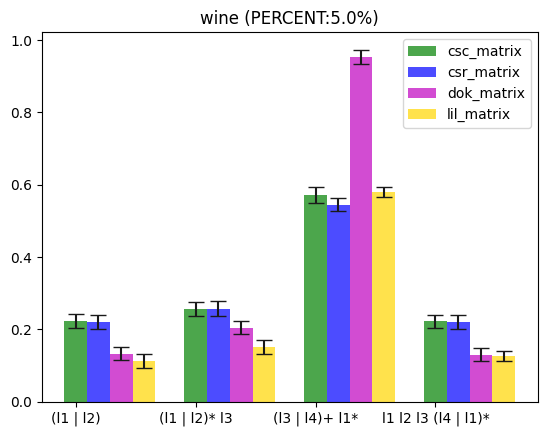

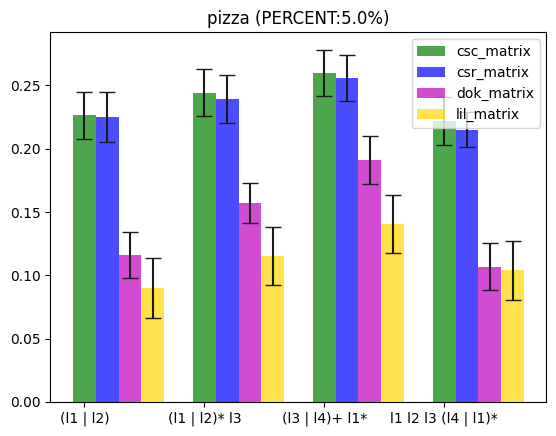

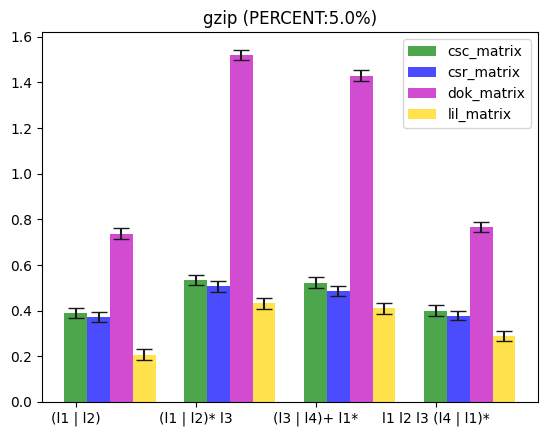

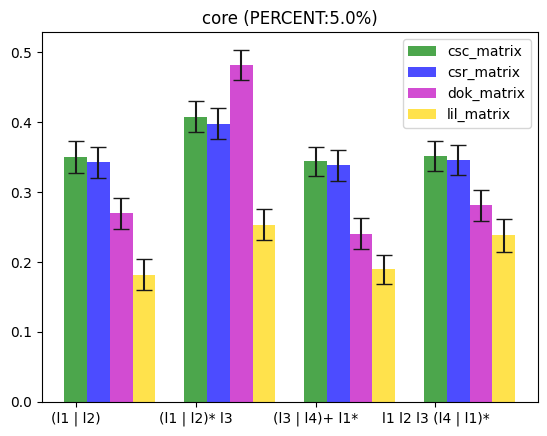

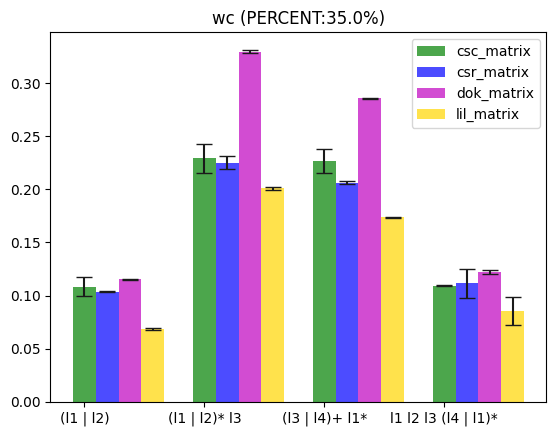

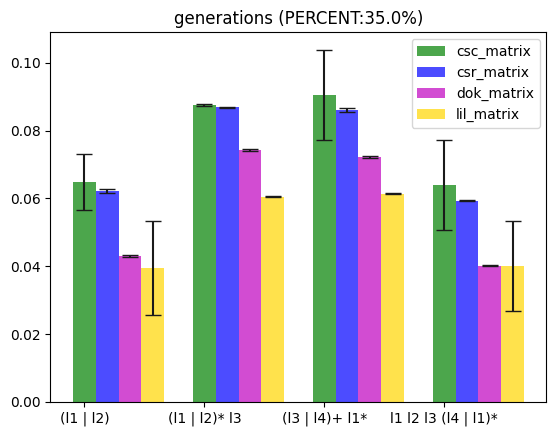

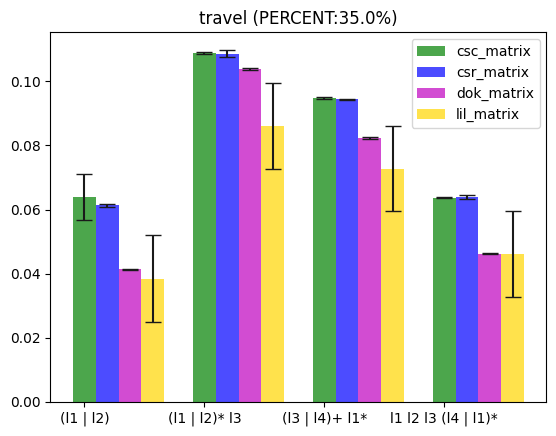

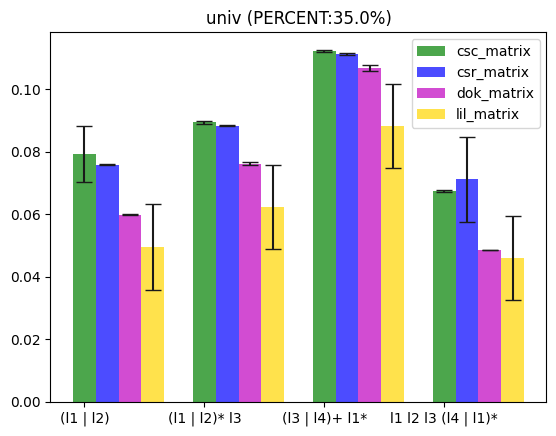

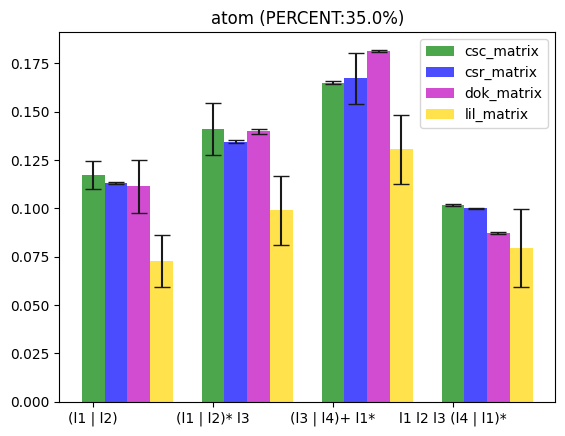

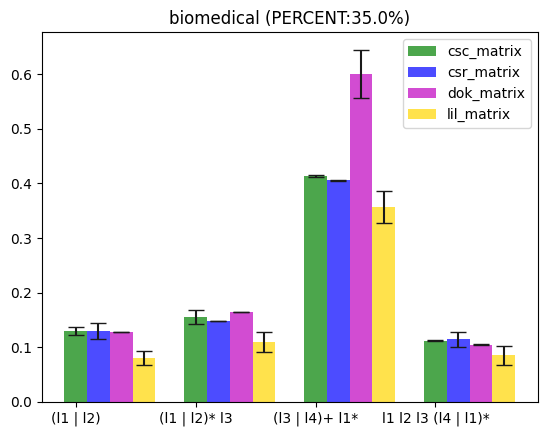

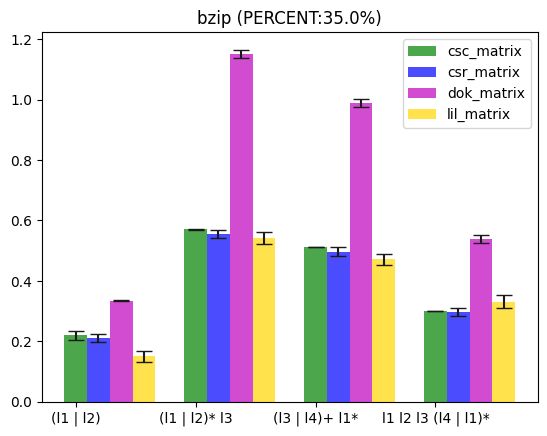

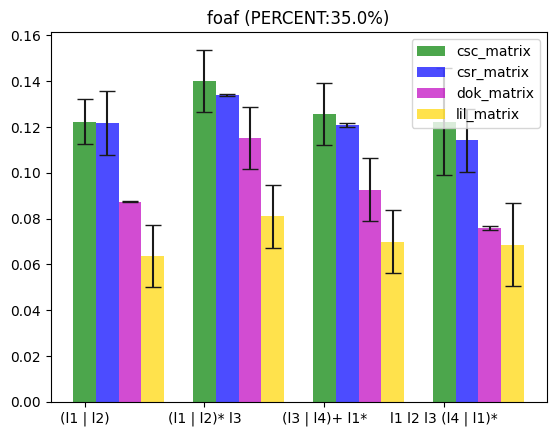

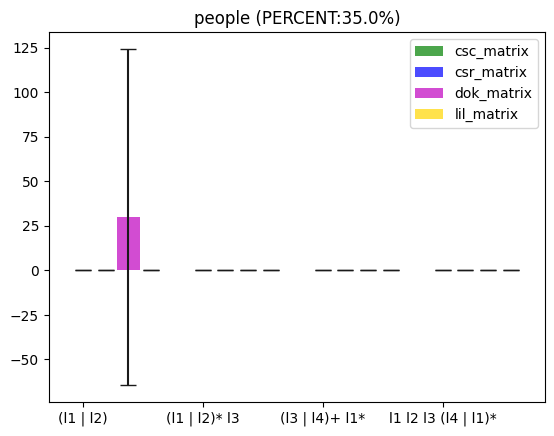

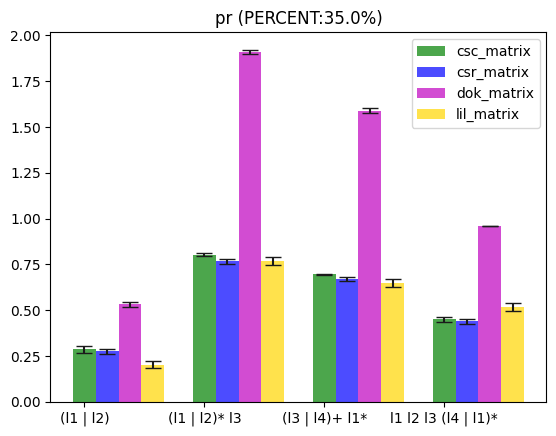

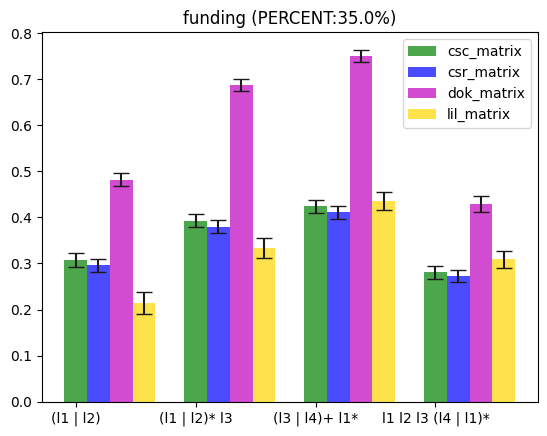

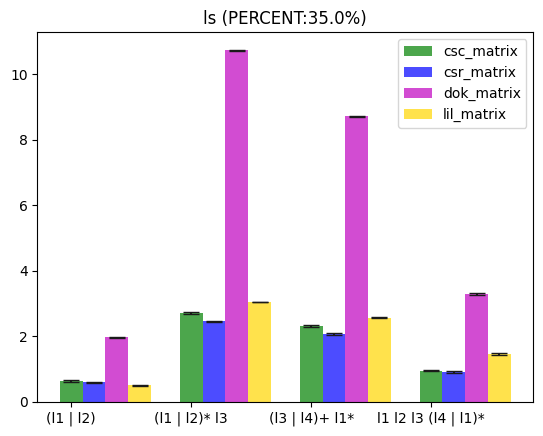

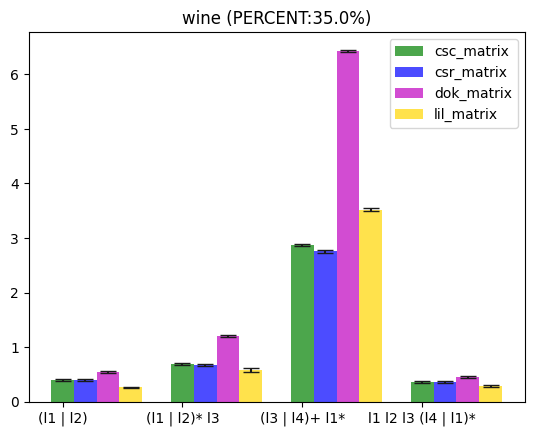

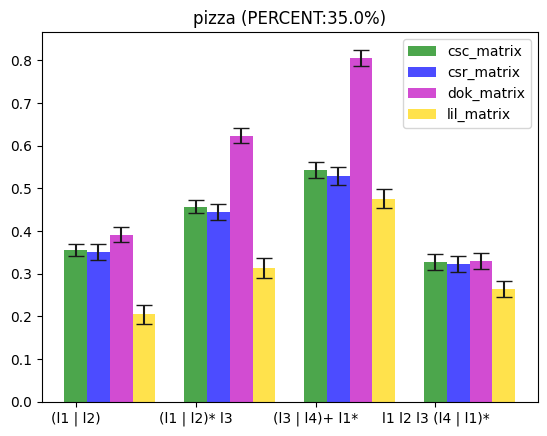

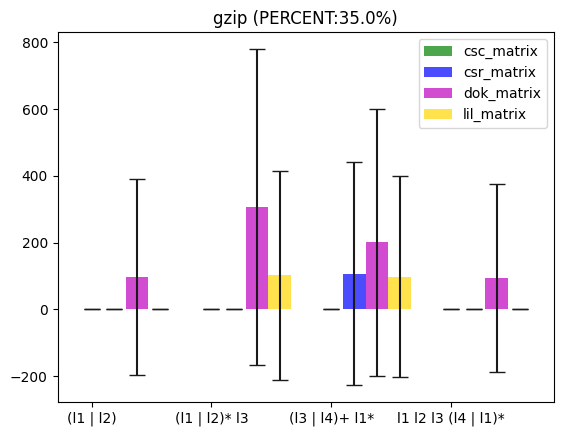

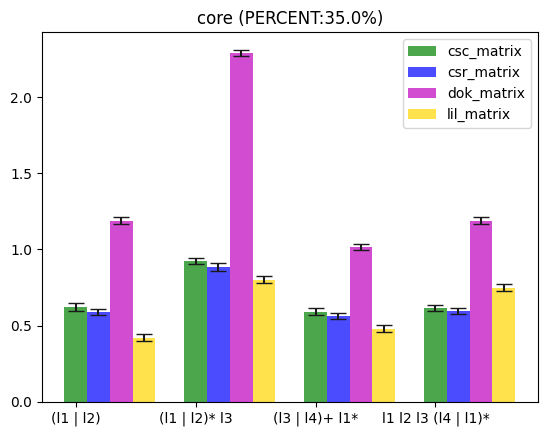

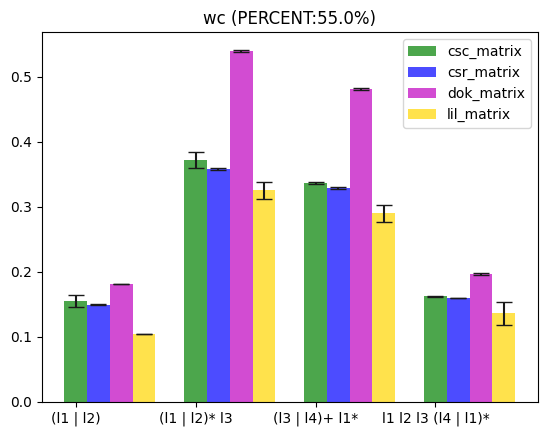

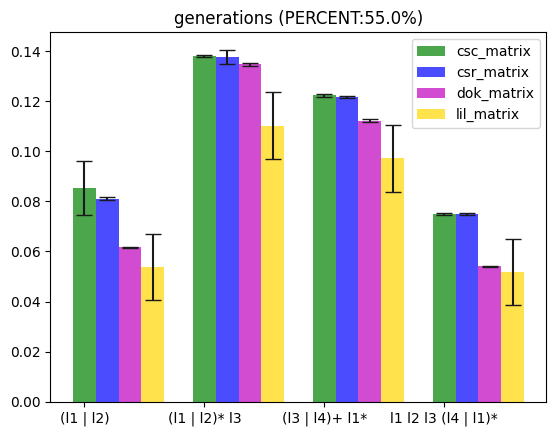

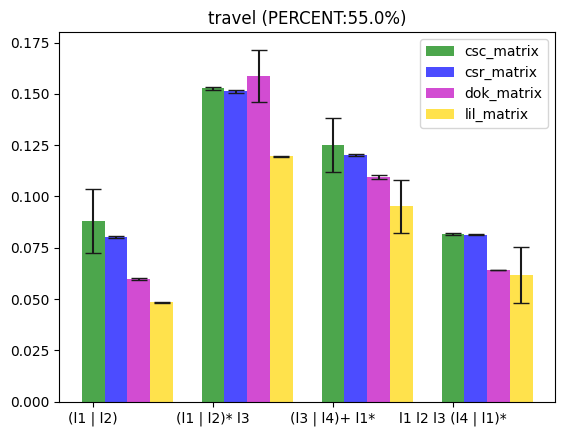

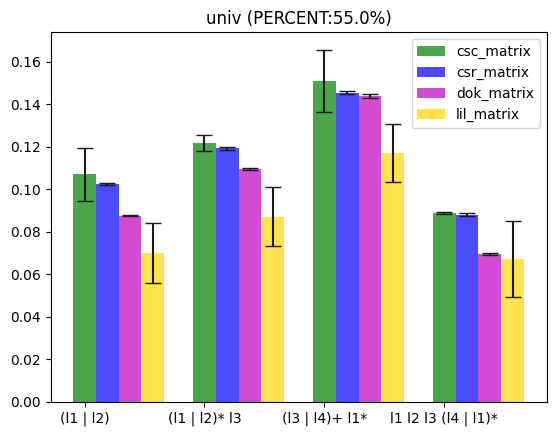

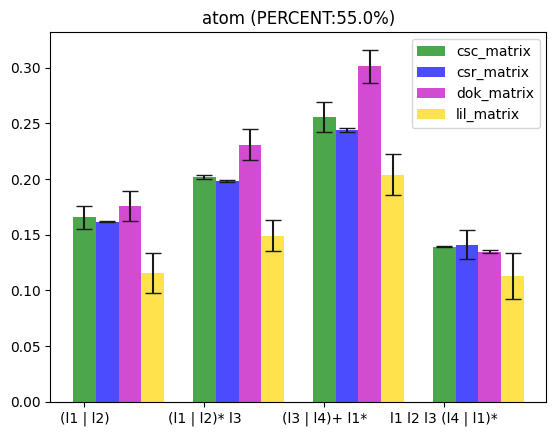

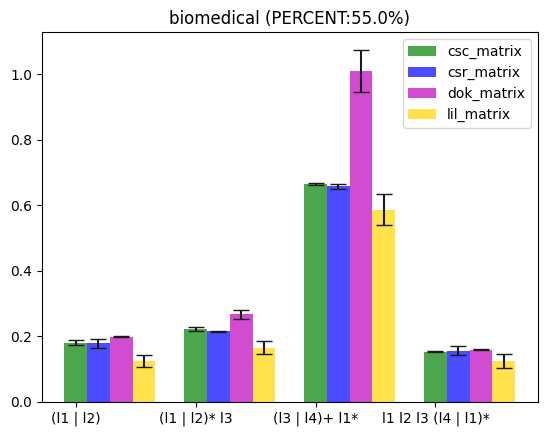

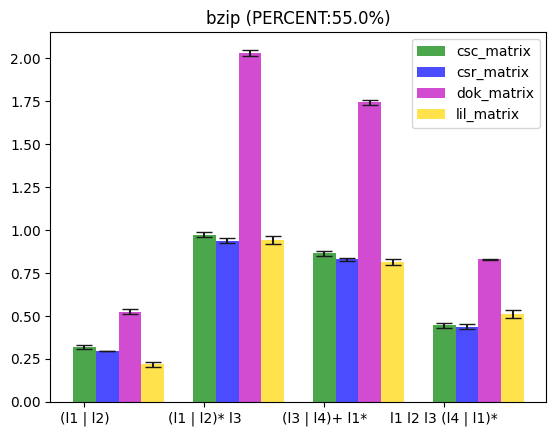

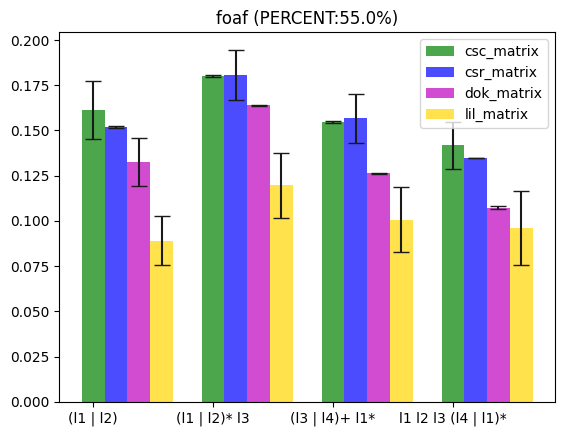

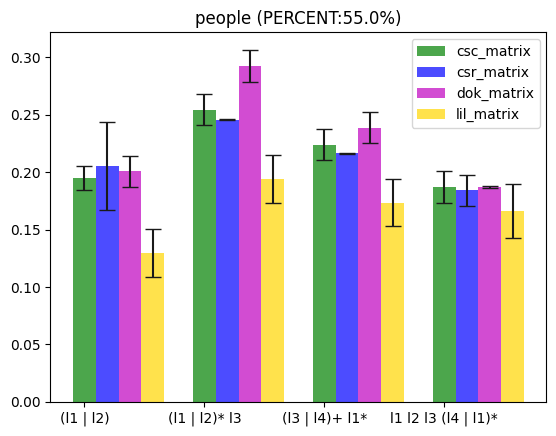

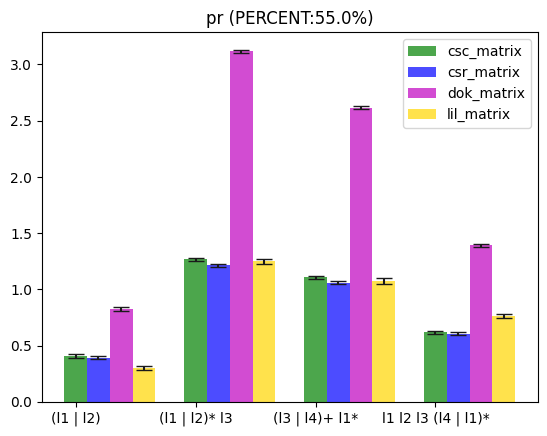

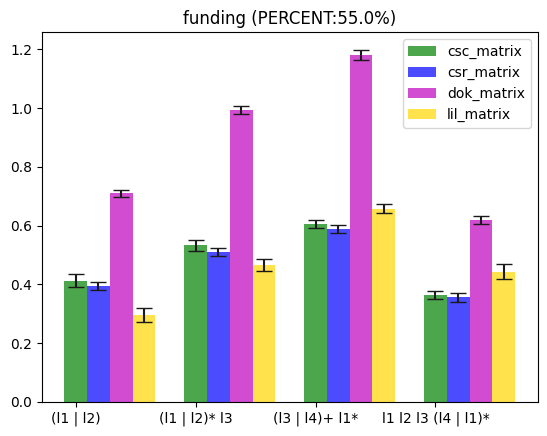

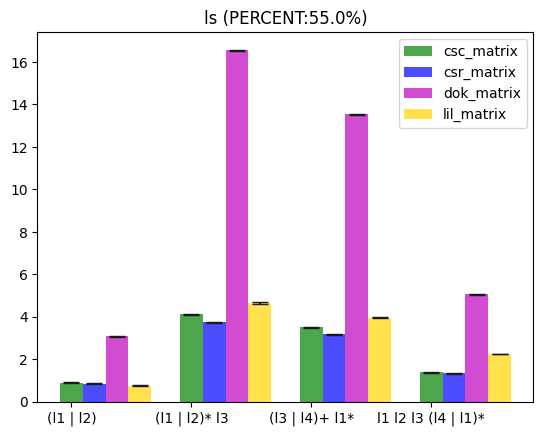

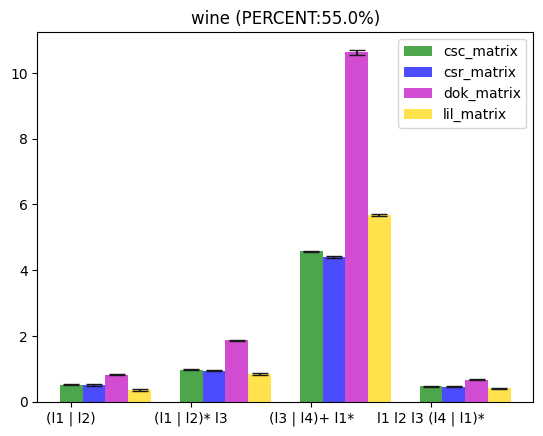

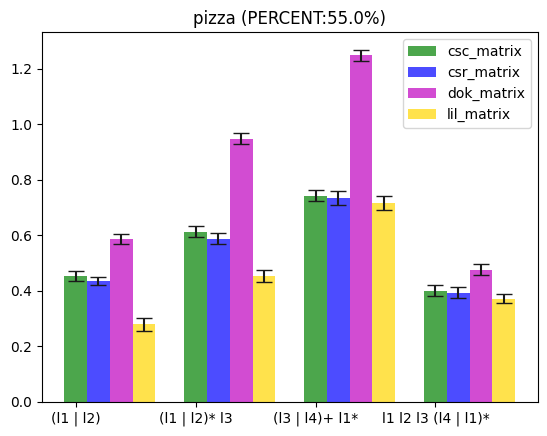

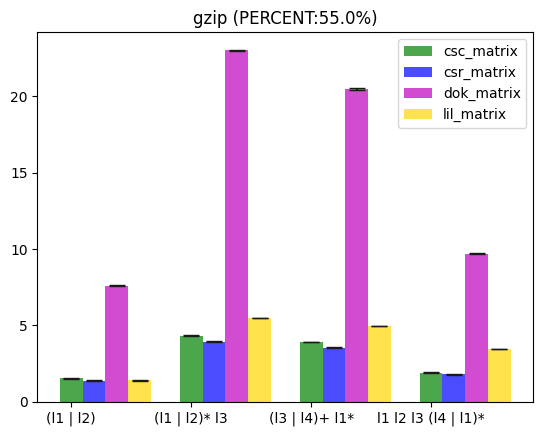

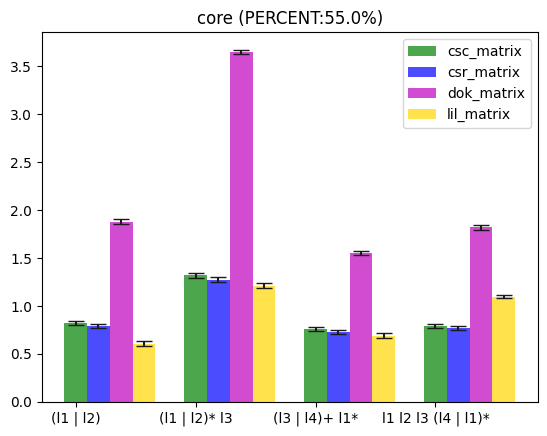

In [30]:
print("Starting 'Достижимость для всего множества заданных вершин: bfs'...")
percents = [5.0, 35.0, 55.0]
for percent in percents:
    _rpq(percent=percent, rpq_type=bfs_rpq, foreach_start_node=False)

### Достижимость для каждой из заданного множества стартовых вершин: tensor multy

In [ ]:
# Same as 'Достижимость для всего множества заданных вершин: tensor multy'
# print("Starting 'Достижимость для каждой из заданного множества стартовых вершин: tensor multy'...")
# percents = [5.0, 35.0, 55.0]
# for percent in percents:
#    _rpq(percent=percent, rpq_type=rpq)

### Достижимость для каждой из заданного множества стартовых вершин: bfs

Starting 'Достижимость для каждой из заданного множества стартовых вершин: bfs'...


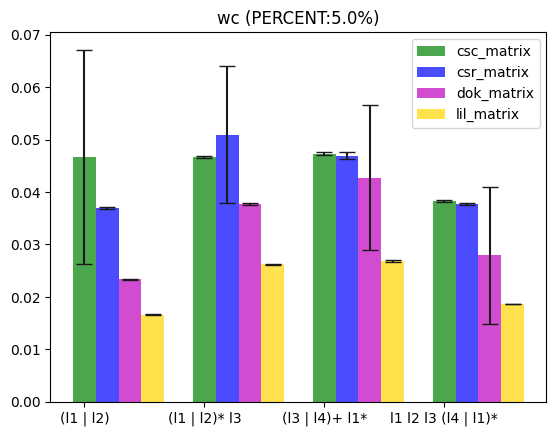

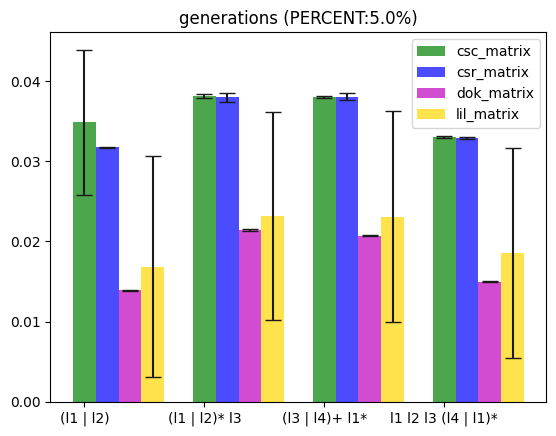

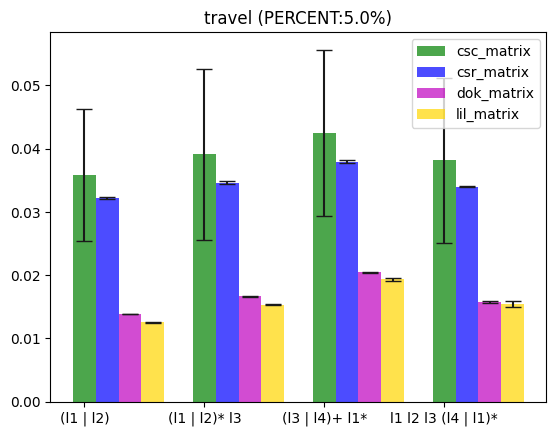

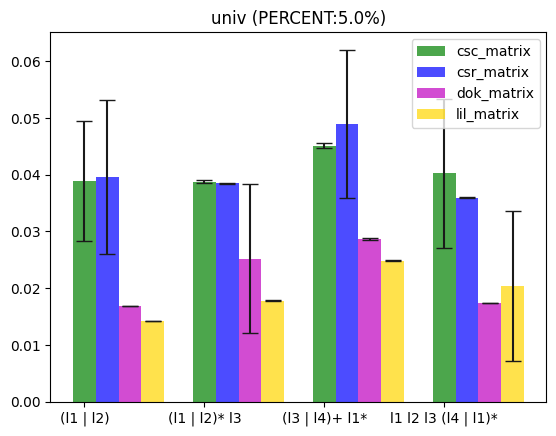

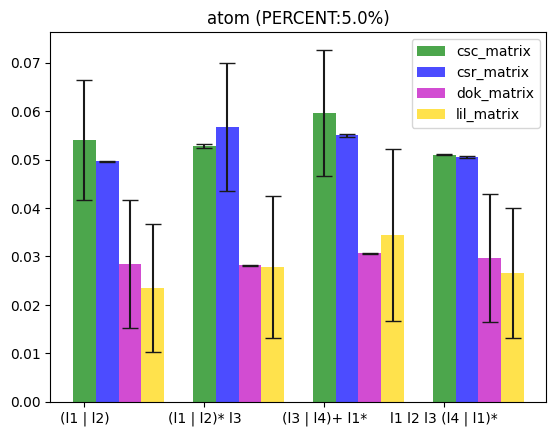

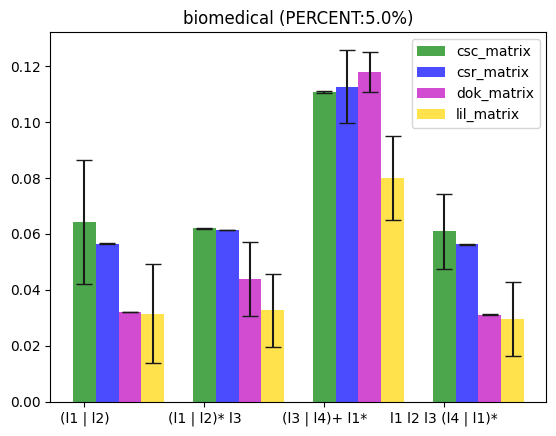

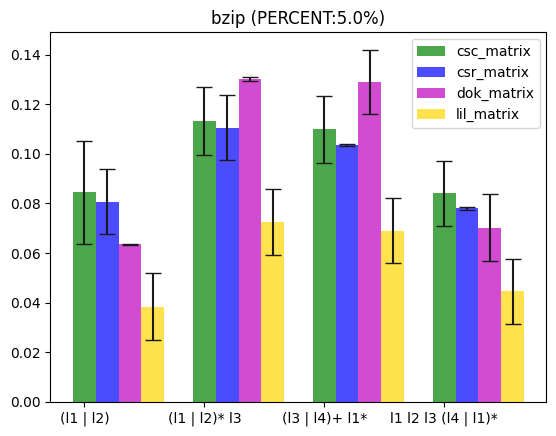

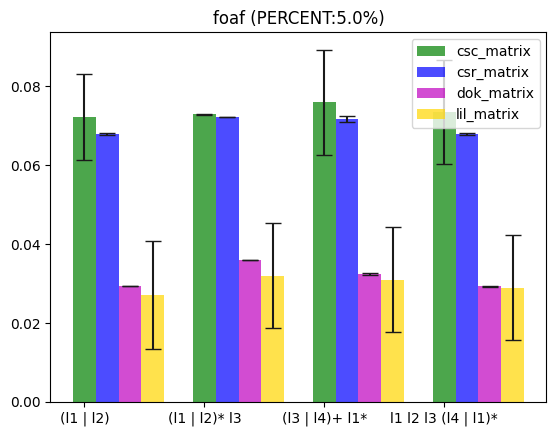

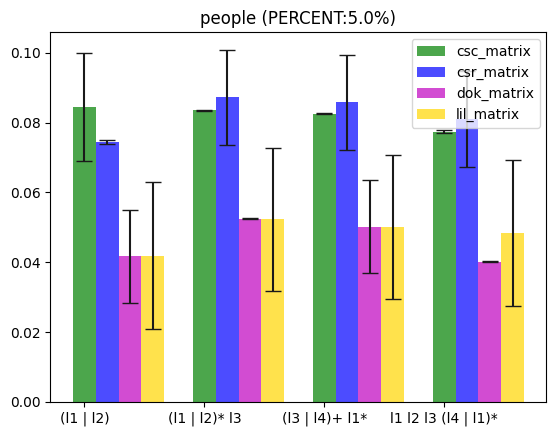

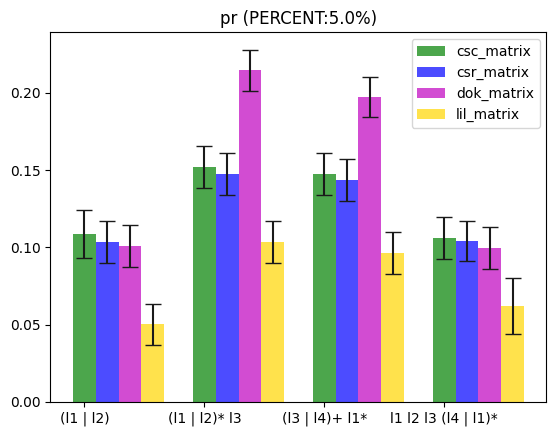

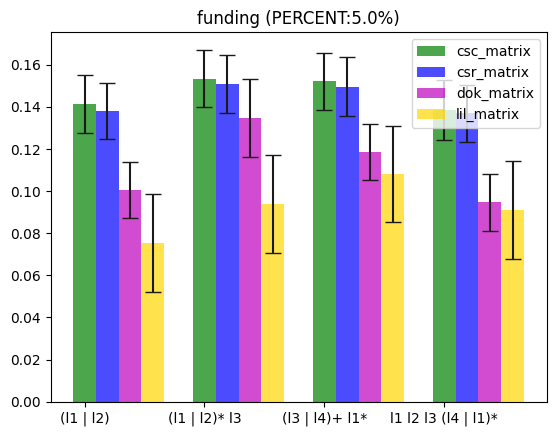

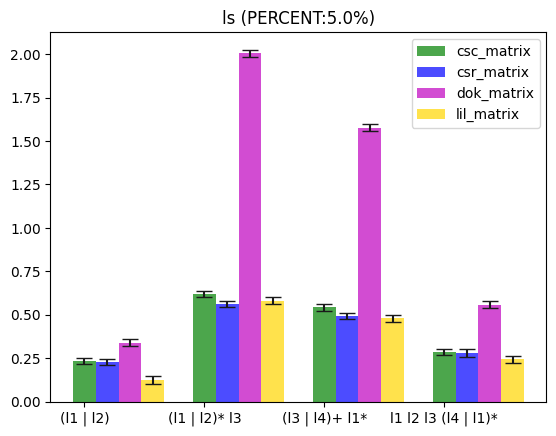

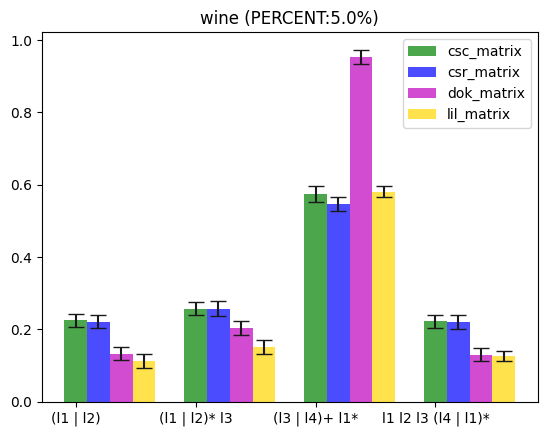

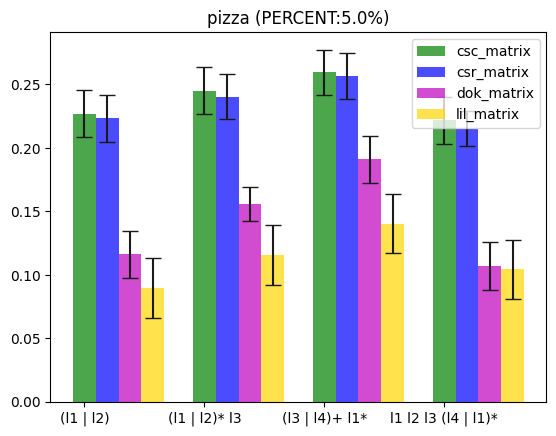

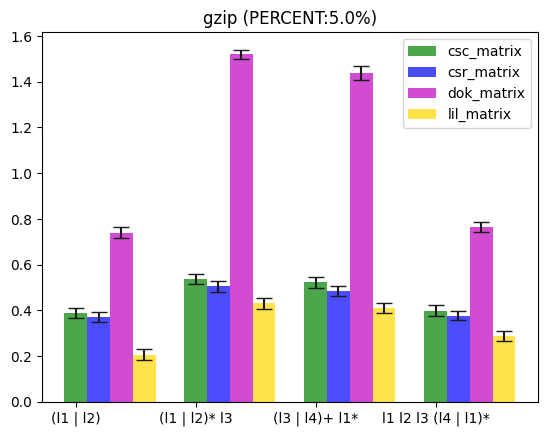

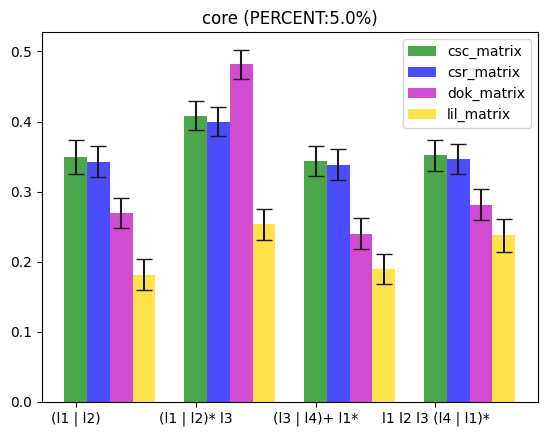

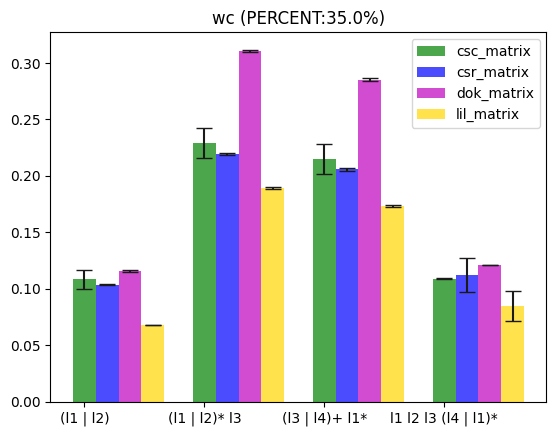

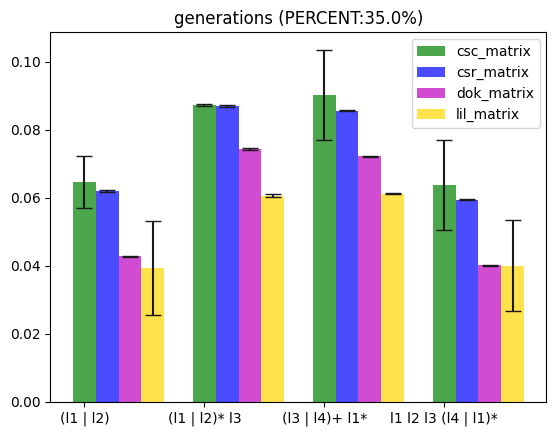

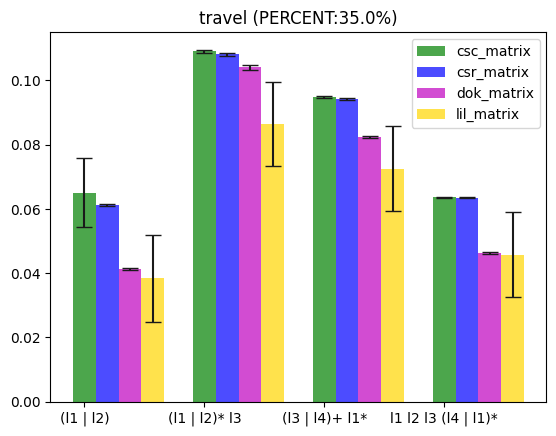

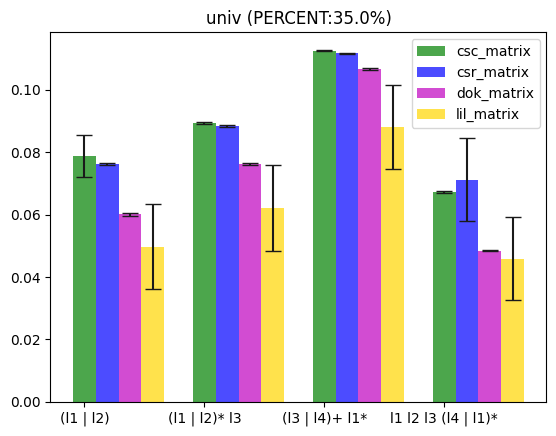

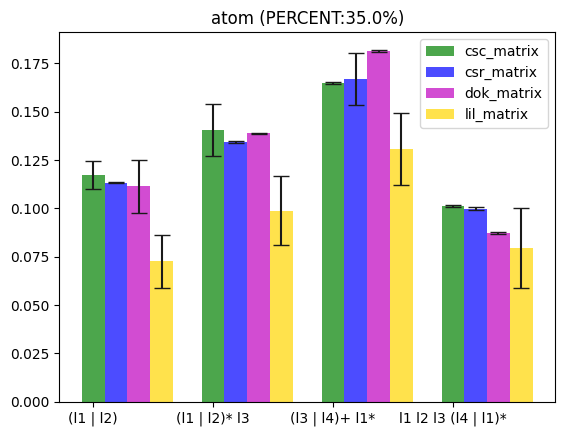

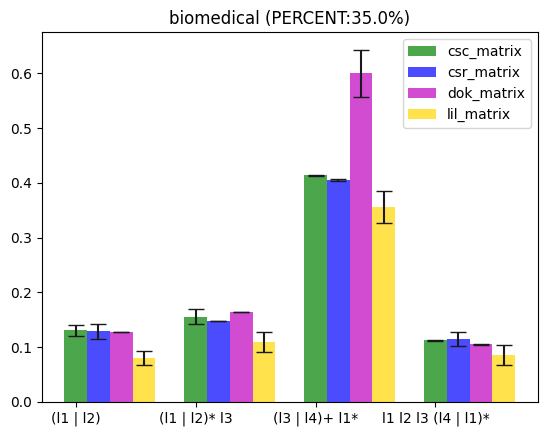

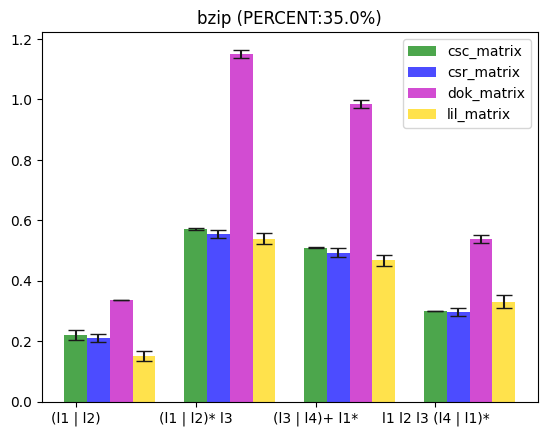

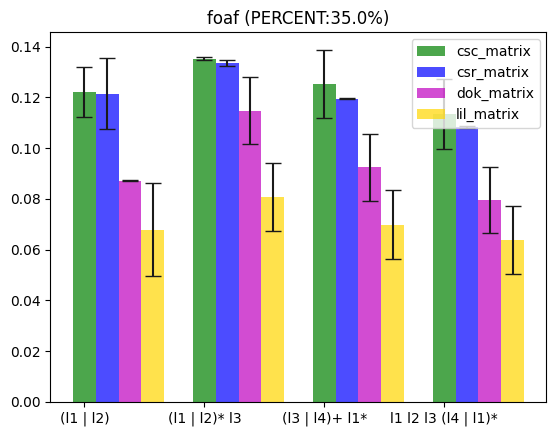

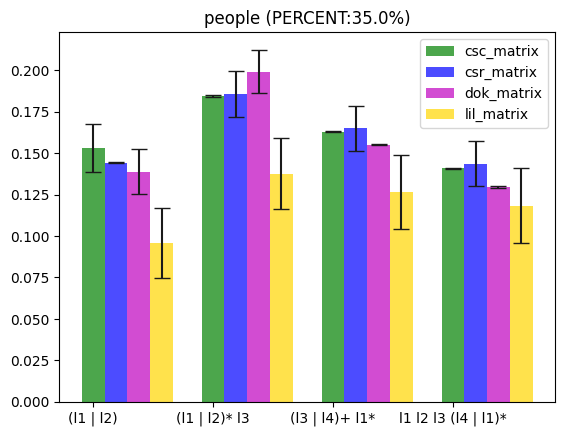

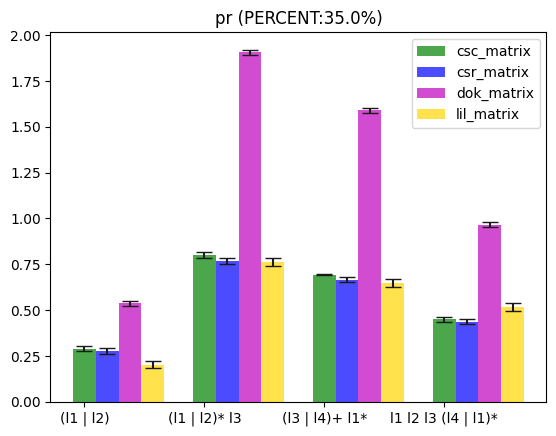

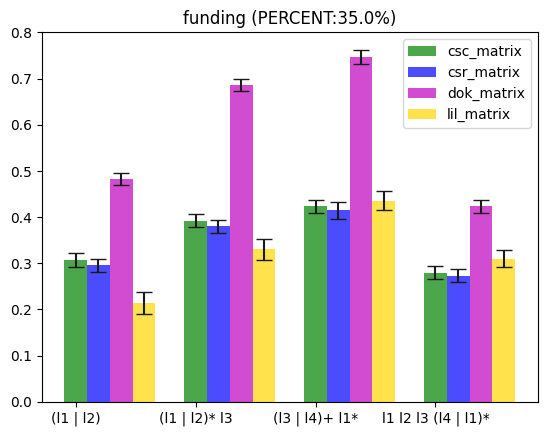

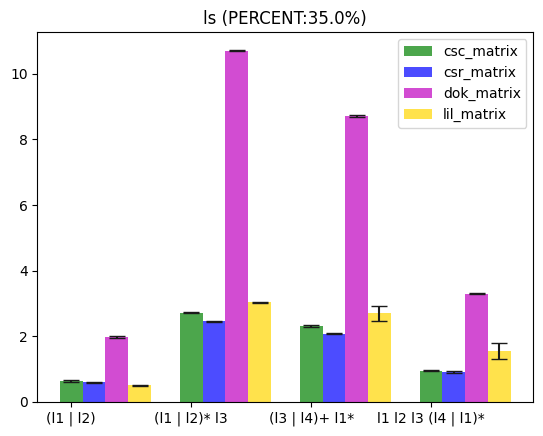

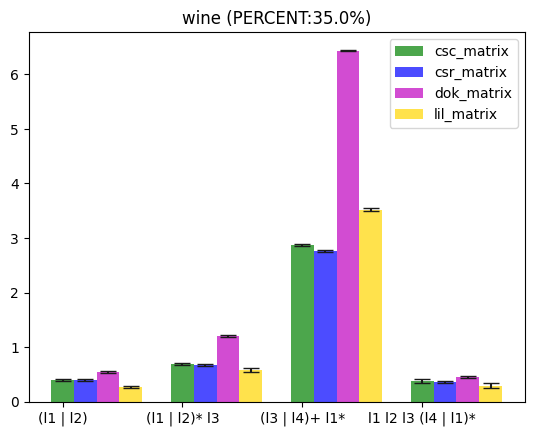

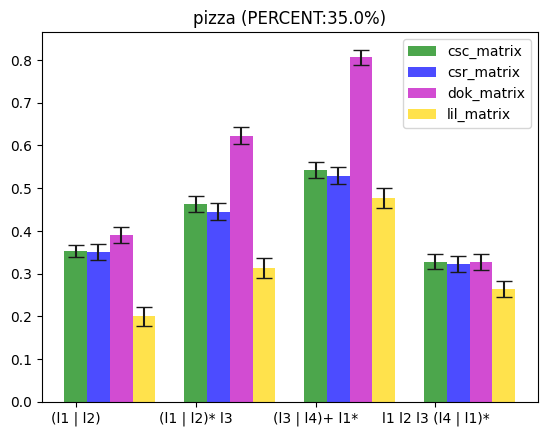

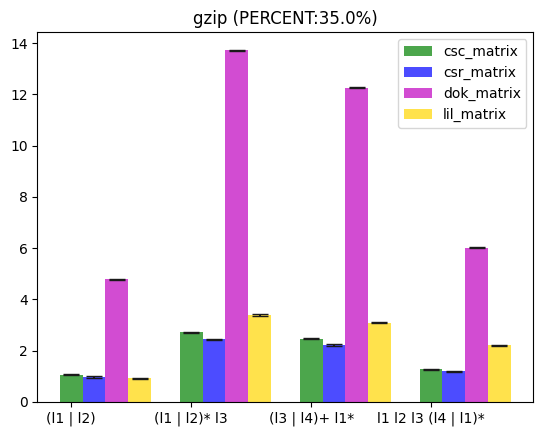

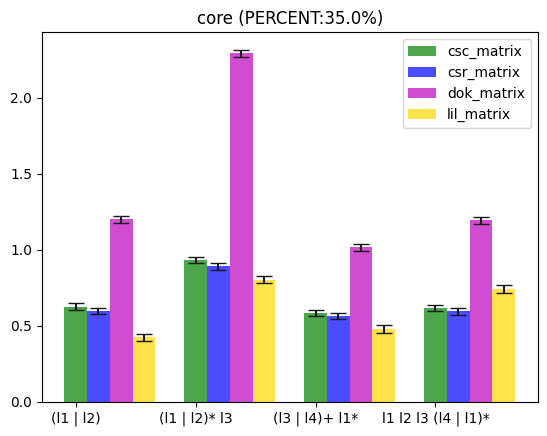

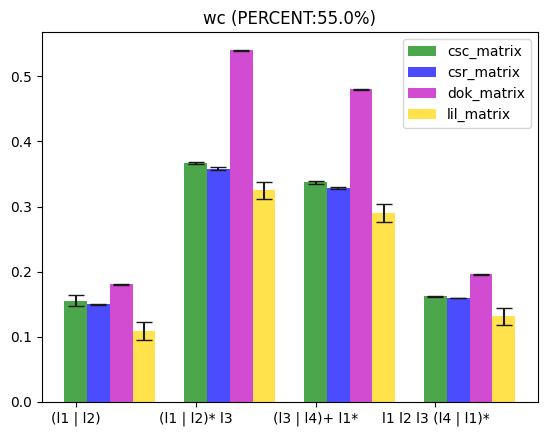

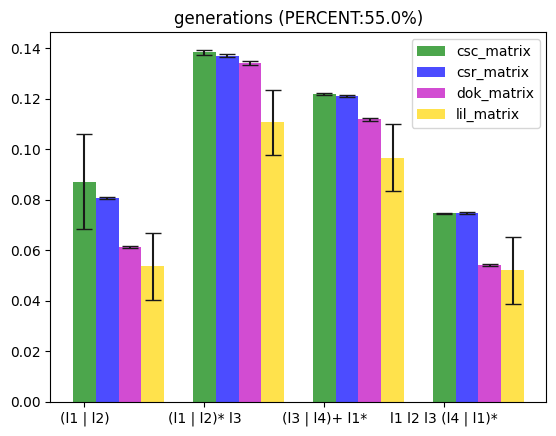

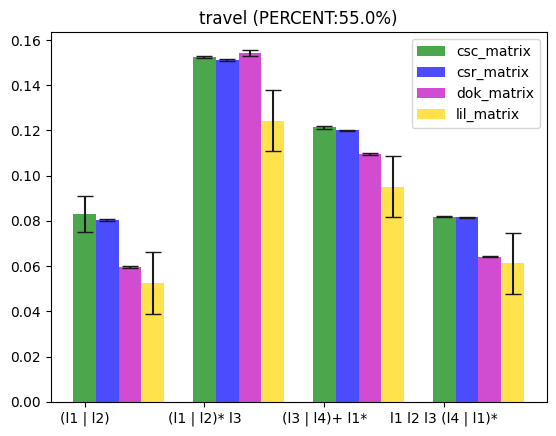

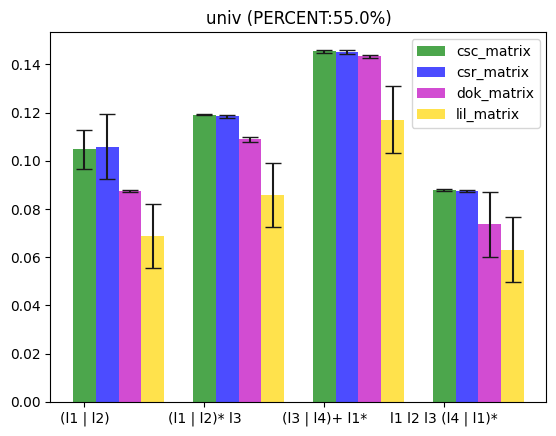

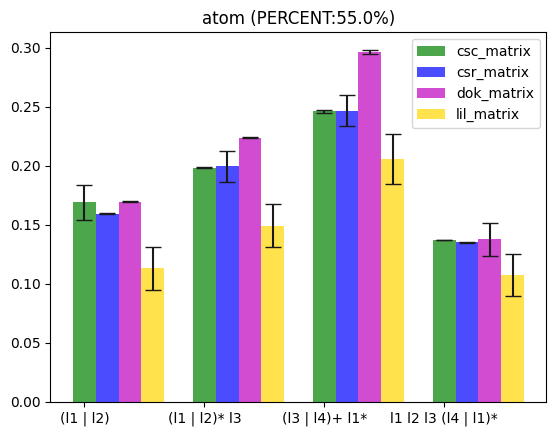

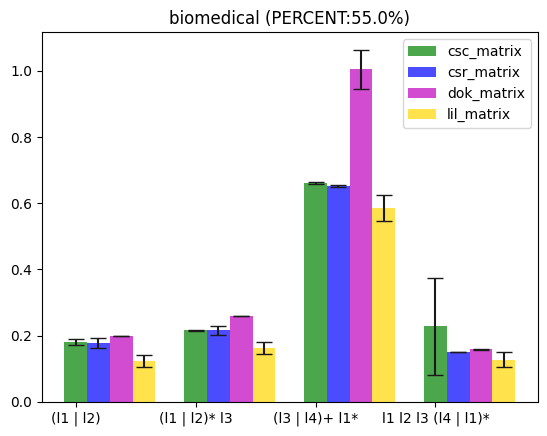

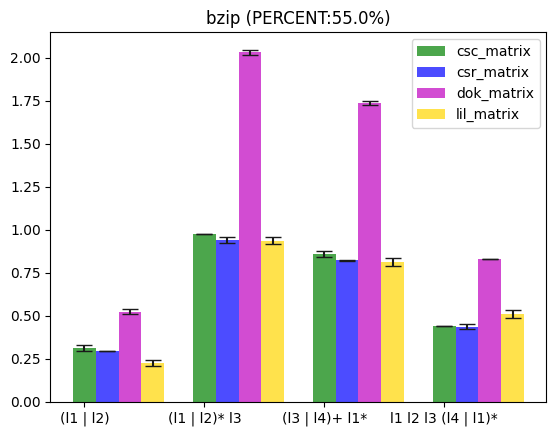

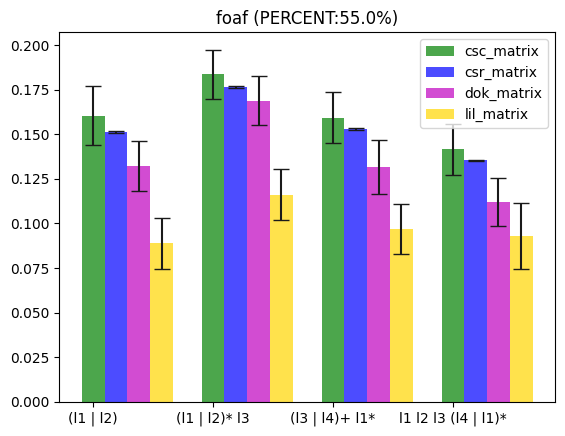

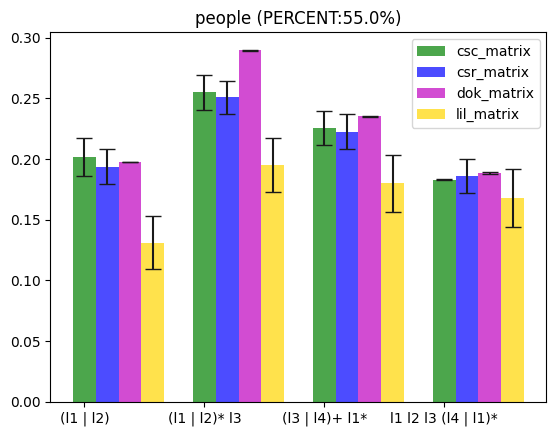

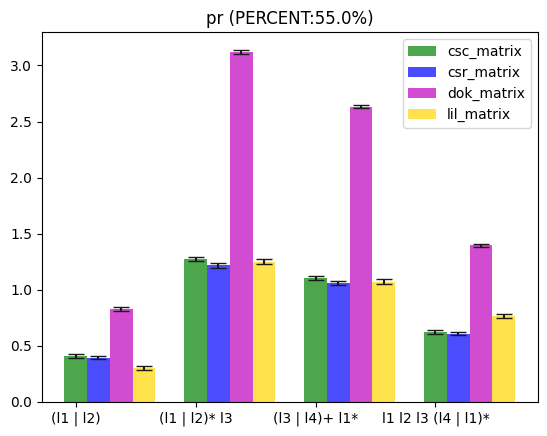

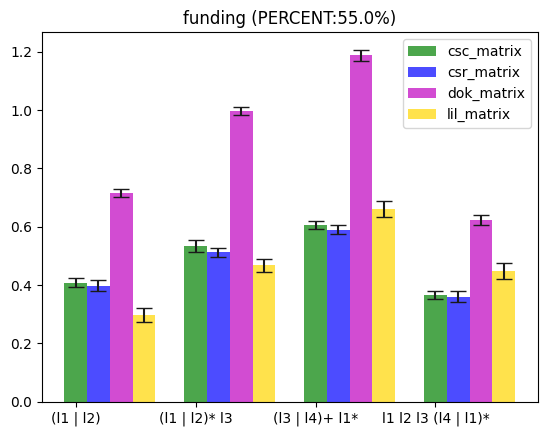

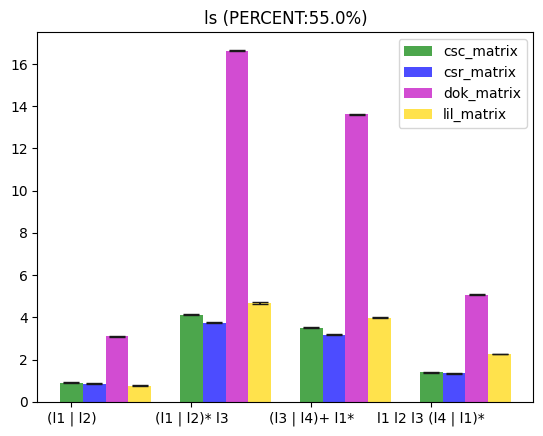

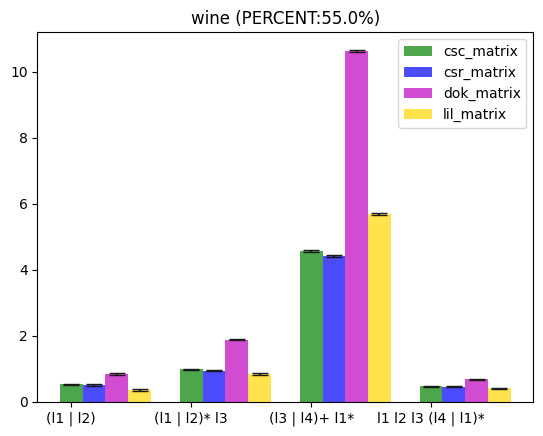

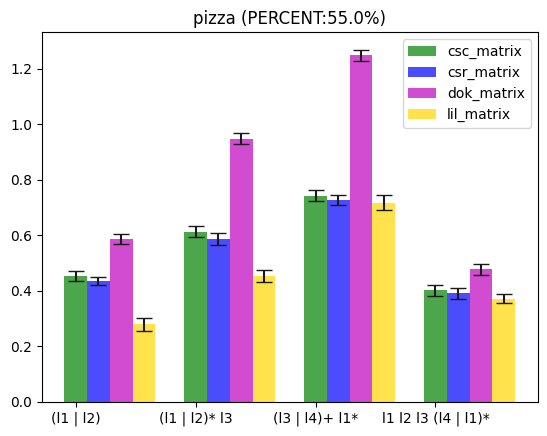

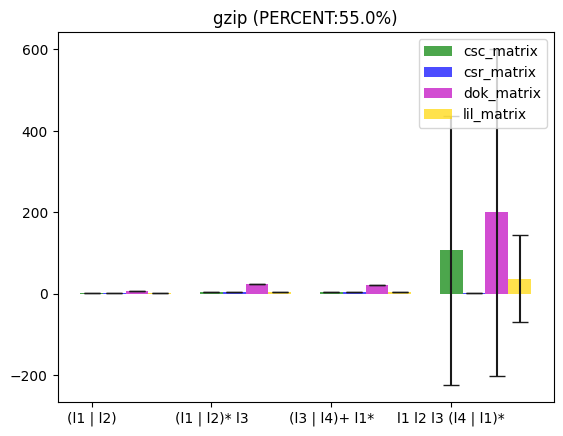

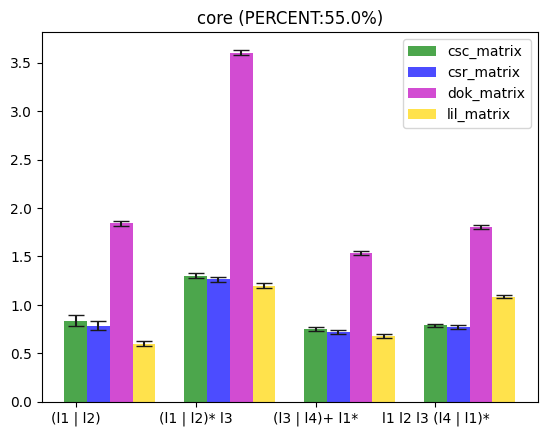

In [31]:
print("Starting 'Достижимость для каждой из заданного множества стартовых вершин: bfs'...")
percents = [5.0, 35.0, 55.0]
for percent in percents:
    _rpq(percent=percent, rpq_type=bfs_rpq)

## Замечания

Во время выполнения **'Достижимость для всего множества заданных вершин: bfs'**[all], а также **'Достижимость для каждой из заданного множества стартовых вершин: bfs'**[each] компьютер несколько раз погружался в спящее состояние, из-за чего диаграммы с использованием графиков
* *people* (35% стартовых вершин)[all],
* *gzip* (35%)[all],
* *gzip* (55%)[each]

получились недостоверными. Тем не менее, они сохраняют общую тенденцию и вписываются в выводы, описанные нами ниже. Достаточно лишь изменить глобальную переменную **GRAPHS** и перезапустить данный notebook, чтобы убедиться в этом.

## Выводы

Подводя итог, можно сделать определенные выводы и ответить на интересующие нас вопросы следующим образом.
* Алгоритм на тензорном произведении показал себя лучше, чем алгоритм с использованием обхода в ширину.
* В большинстве своем, **lil_matrix** показывает себя лучше всех, в то время, как **dok_matrix**, наоборот, очень часто требует больше всех времени на выполнение (**csc_matrix** и **csr_matrix** показывают себя средне, при этом --- почти одинаково). Стоит отметить, что данный вывод характерен для каждой из задач.
* Говоря про анализируемые нами графы из датасета (до ~3000 ребер и ~1500 вершин), можно сделать вывод о том, что на указанном выше железе алгоритмы достижимости **для каждой стартовой вершины из заданного множества** и **для всего класса в целом** (bfs) отрабатывают с приблизительно равным количеством времени независимо от количества стартовых вершин (15%, 35%, 55%). Тенденция, однако, такова, что с дальнейшим ростом процента стартовых вершин, а также размеров графов, первый алгоритм будет занимать больше времени в силу бОльшего количества матричных умножений, однако для того, чтобы убедиться в этом, требуется более мощное оборудование, поскольку рендеринг диаграмм выше занял у нас очень много времени (более трех часов).